In [1]:
import sys

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/src/data"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc, skew, kurtosis
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian

from utils import set_global_seed
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

In [ ]:
# Define and fix seed
SEED: int = 20
set_global_seed(SEED)

# Specify the parameter to be varied and it's symbol
VARYING_PARAM: str = "inertia"
VARYING_PARAM_NOTATION: str = "m"

# Boolean constant only adds title on subplots on the top most row (first random seed 0)
TOP_PLOT: bool = True

# Specify the range of parameter values
PARAM_LIST: list[float] = [0.00025, 0.0025, 0.025, 0.25, 2.5]
#[0.00015, 0.0015, 0.015, 0.15, 1.5]
DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
# INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])

# Path to save images and flag
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                        f"/dissertation_code/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

SAVE: bool = False

In [3]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

CMAP: str = "seismic"  # Color map for the visualisations

# Move tensors and models to GPU
# DEVICE: str = torch.device("mps" if torch.backends.mps.is_available else "cpu")
DEVICE: str = "cpu"

# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float32
).to(device=DEVICE)

# Boolean constant for whether or not PI controllers included
CONTROLLERS: bool = False

# PINN Hyperparameter constants
LEARNING_RATE: float = 0.01
# SCHEDULER_STEP_SIZE: int = 200
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9
EPOCHS: int = 25_000
N_C: int = 1_000  # Number of collocation points

# PINN soft regularisation weights in the loss function
PHYSICS_WEIGHT: float = 1.0
IC_WEIGHT: float = 1.0

# Specify activation function
ACTIVATION: str = "tanh"

# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
collocation_points = LHC.random(n=N_C)
collocation_points = qmc.scale(
    collocation_points, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

collocation_points: torch.tensor = torch.tensor(
    data=collocation_points[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)

## This cell contains a parameter which must be changed

In [4]:
numerical_solutions_exact = []
numerical_solutions_noisy = []
numerical_domain = None

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)

# Define percentage of total dataset N to select for training
TRAIN_TEST_SPLIT: float = 0.3

for param in PARAM_LIST:

    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=param,
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    # solution, noisy_solution, numerical_times = swing_ODEs_solver(
    #     initial_time=0,
    #     initial_state=INITIAL_STATE.detach().numpy(),
    #     final_time=20.0,
    #     timestep=0.1,
    #     inertia=0.25,
    #     damping=param,
    #     mechanical_power=0.13,
    #     voltage_magnitude=1.0,
    #     include_controllers=False,
    #     voltages=np.array([1.0]),
    #     phase_angles=np.array([0.0]),
    #     susceptances=np.array([0.2]),
    #     file_name="test_run",
    #     save_output_to_file=False,
    #     controller_proportional=0.05,
    #     controller_integral=0.1
    # )

    if numerical_domain is None:
        numerical_domain = numerical_times

    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

# Also create PyTorch tensors
numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact).to(device=DEVICE)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy).to(device=DEVICE)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True).to(device=DEVICE)

# Obtain a random array of index to index the numerical solution on to obtain training data
# for vanilla NN
rand_index = np.random.choice(np.arange(1, N, 1), replace=False, size=int(np.floor(N*TRAIN_TEST_SPLIT)))
rand_index = np.append(rand_index, 0)
rand_index.shape

(61,)

In [5]:
test_indices = np.setdiff1d(np.arange(0, N, 1), rand_index)
assert int(test_indices.shape[0] + rand_index.shape[0]) == N

In [6]:
# Define subspace mesh
LB: int = -5
NUM_VERTICES: int = 40
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(model=PINN(activation=ACTIVATION).to(device=DEVICE)).total_params

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vectors
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into unit vector
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-6
assert torch.norm(input=direction_vec_1) - 1 < 1e-8
assert torch.norm(input=direction_vec_2) - 1 < 1e-8

In [7]:
# Collect all trained PINN models for each parameter
pinn_models = []

# Collect training losses across each parameter value
training_losses_per_param = []

# Collect residual losses across each parameter value
residual_losses_per_param = []

# Collect test losses per epoch across each parameter
test_losses_per_param_per_epoch = []

# Collect summary statistics of the distribution of residual values per epoch per parameter
skewness_per_param = []
kurtosis_per_param = []

# Iterate over all parameter values
for index, param in enumerate(PARAM_LIST):

    print(f"Param value {index+1}")
    print("----------------------\n")

    ######################################################
    # SPECIFY VARIABLE PARAMETER
    ######################################################
    INERTIA: torch.Tensor = torch.tensor(data=[[param]])

    # Define PINN, optimiser and learning rate scheduler
    pinn = PINN(activation=ACTIVATION).to(device=DEVICE)

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser = torch.optim.Adam(params=pinn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    # Define list to collect total training loss every epoch
    training_loss = []

    # Define list to collect residual loss every epoch
    residual_loss = []

    # Define list to collect test losses every epoch (L2 relative error)
    test_loss = []

    # Define two lists to collect skewness and kurtosis values per epoch of the residual loss distributions
    kurtosis_list = []
    skewness_list = []

    # Perform the training loop using full-batch training
    for epoch in tqdm(range(EPOCHS)):

        # Obtain PINN rediction at current state for test set and evaluate performance
        ground_truth_phase_angle = numerical_solutions_exact_tensor[index, 0, :]
        ground_truth_angular_frequency = numerical_solutions_exact_tensor[index, 1, :]
        
        phase_angle_pred_test = pinn.forward(data=times_tensor, initial_state=INITIAL_STATE)

        angular_frequency_pred_test = torch.autograd.grad(
            outputs=phase_angle_pred_test,
            inputs=times_tensor,
            grad_outputs=torch.ones_like(phase_angle_pred_test),
            create_graph=True,
            retain_graph=True,
        )[0]

        pred_vector = torch.stack(tensors=(phase_angle_pred_test, angular_frequency_pred_test), dim=0).squeeze()
        label_vector = torch.stack(tensors=(ground_truth_phase_angle, ground_truth_angular_frequency), dim=0)

        _, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)
        test_loss.append(l2_rel.item())

        # Obtain PINN predictions and it's time derivatives
        phase_angle_pred = pinn.forward(
            data=collocation_points, initial_state=INITIAL_STATE
        )

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_points,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=INERTIA,
            damping=DAMPING,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        loss_func = loss_closure(
            swing_inputs=swing_inputs,
            physics_weight=PHYSICS_WEIGHT,
            IC_weight=IC_WEIGHT,
            model=pinn,
            initial_state=INITIAL_STATE,
            device=DEVICE,
            include_controllers=CONTROLLERS,
        ) 

        # Obtain residual loss (no backprop)
        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False).item()
        residual_loss.append(residual)

        # Compute summary statistics of the distribution of residuals at the given epoch
        skewness_val = skew(a=np.array(residual_loss))
        kurtosis_val = kurtosis(a=np.array(residual_loss), fisher=True)

        skewness_list.append(skewness_val)
        kurtosis_list.append(kurtosis_val)

        # Obtain the total loss and backpropogate on that value
        loss = loss_func(inputs=None, targets=None)
        training_loss.append(loss.item())

        # Backpropogate using reverse/backward-mode AD
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step(metrics=loss)

        if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
            print(f"Training loss: {loss}")

    
    # Append the trained model and the training losses per epoch to the respective lists
    pinn_models.append(pinn)
    training_losses_per_param.append(training_loss)
    residual_losses_per_param.append(residual_loss)
    test_losses_per_param_per_epoch.append(test_loss)
    skewness_per_param.append(skewness_list)
    kurtosis_per_param.append(kurtosis_list)

Param value 1
----------------------



  0%|          | 60/25000 [00:00<01:22, 303.17it/s]

Training loss: 0.037581123411655426


  1%|          | 153/25000 [00:00<01:24, 292.76it/s]

Training loss: 0.00020646245684474707


  1%|          | 251/25000 [00:00<01:20, 306.98it/s]

Training loss: 0.00013603674597106874


  1%|▏         | 346/25000 [00:01<01:26, 286.33it/s]

Training loss: 9.394504741067067e-05


  2%|▏         | 432/25000 [00:01<01:28, 277.97it/s]

Training loss: 0.0001443926157662645


  2%|▏         | 550/25000 [00:01<01:24, 288.84it/s]

Training loss: 0.00012672382581513375


  3%|▎         | 646/25000 [00:02<01:20, 302.41it/s]

Training loss: 0.00012005383905488998


  3%|▎         | 735/25000 [00:02<01:26, 281.78it/s]

Training loss: 0.0001173052005469799


  3%|▎         | 864/25000 [00:02<01:17, 311.33it/s]

Training loss: 0.00011615789117058739


  4%|▎         | 927/25000 [00:03<01:21, 296.86it/s]

Training loss: 0.00011567877663765103


  4%|▍         | 1049/25000 [00:03<01:20, 299.37it/s]

Training loss: 0.00011547930625965819


  5%|▍         | 1143/25000 [00:03<01:21, 294.18it/s]

Training loss: 0.00011539670231286436


  5%|▍         | 1239/25000 [00:04<01:18, 303.00it/s]

Training loss: 0.00011536266538314521


  5%|▌         | 1339/25000 [00:04<01:18, 302.93it/s]

Training loss: 0.00011534936493262649


  6%|▌         | 1432/25000 [00:04<01:20, 292.96it/s]

Training loss: 0.00011534474469954148


  6%|▌         | 1553/25000 [00:05<01:22, 285.36it/s]

Training loss: 0.00011534337681951001


  7%|▋         | 1639/25000 [00:05<01:26, 271.55it/s]

Training loss: 0.00011534283112268895


  7%|▋         | 1749/25000 [00:06<01:29, 260.31it/s]

Training loss: 0.00011534223449416459


  7%|▋         | 1846/25000 [00:06<01:17, 300.30it/s]

Training loss: 0.00011534171790117398


  8%|▊         | 1938/25000 [00:06<01:19, 289.26it/s]

Training loss: 0.00011534103396115825


  8%|▊         | 2059/25000 [00:07<01:17, 295.41it/s]

Training loss: 0.0001153403427451849


  9%|▊         | 2150/25000 [00:07<01:18, 290.16it/s]

Training loss: 0.00011533949873410165


  9%|▉         | 2239/25000 [00:07<01:20, 282.94it/s]

Training loss: 0.00011533864017110318


  9%|▉         | 2354/25000 [00:08<01:22, 276.00it/s]

Training loss: 0.0001153377816081047


 10%|▉         | 2438/25000 [00:08<01:22, 273.42it/s]

Training loss: 0.0001153368066297844


 10%|█         | 2550/25000 [00:08<01:25, 263.69it/s]

Training loss: 0.00011533567885635421


 11%|█         | 2642/25000 [00:09<01:17, 287.07it/s]

Training loss: 0.0001153345947386697


 11%|█         | 2738/25000 [00:09<01:14, 299.72it/s]

Training loss: 0.00011533332872204483


 11%|█▏        | 2829/25000 [00:09<01:15, 291.87it/s]

Training loss: 0.00011533190263435245


 12%|█▏        | 2946/25000 [00:10<01:18, 281.60it/s]

Training loss: 0.00011533039651112631


 12%|█▏        | 3038/25000 [00:10<01:14, 294.88it/s]

Training loss: 0.00011532878124853596


 13%|█▎        | 3134/25000 [00:10<01:10, 308.12it/s]

Training loss: 0.00011532691860338673


 13%|█▎        | 3266/25000 [00:11<01:08, 316.73it/s]

Training loss: 0.00011532509961398318


 13%|█▎        | 3330/25000 [00:11<01:10, 306.35it/s]

Training loss: 0.00011532306234585121


 14%|█▍        | 3458/25000 [00:11<01:08, 313.12it/s]

Training loss: 0.00011532107600942254


 14%|█▍        | 3554/25000 [00:12<01:09, 310.39it/s]

Training loss: 0.00011531882046256214


 15%|█▍        | 3649/25000 [00:12<01:11, 299.23it/s]

Training loss: 0.00011531629570527002


 15%|█▍        | 3737/25000 [00:12<01:14, 287.31it/s]

Training loss: 0.00011531363270478323


 15%|█▌        | 3863/25000 [00:13<01:09, 305.45it/s]

Training loss: 0.0001153107950813137


 16%|█▌        | 3955/25000 [00:13<01:11, 294.98it/s]

Training loss: 0.00011530779738677666


 16%|█▌        | 4044/25000 [00:13<01:13, 283.67it/s]

Training loss: 0.00011530460324138403


 17%|█▋        | 4132/25000 [00:14<01:13, 285.61it/s]

Training loss: 0.00011530135088833049


 17%|█▋        | 4254/25000 [00:14<01:10, 295.04it/s]

Training loss: 0.00011529788753250614


 17%|█▋        | 4347/25000 [00:14<01:08, 301.12it/s]

Training loss: 0.00011529437324497849


 18%|█▊        | 4444/25000 [00:15<01:07, 305.84it/s]

Training loss: 0.00011529082257766277


 18%|█▊        | 4540/25000 [00:15<01:06, 307.80it/s]

Training loss: 0.00011528680624905974


 19%|█▊        | 4633/25000 [00:15<01:07, 301.24it/s]

Training loss: 0.000115282426122576


 19%|█▉        | 4756/25000 [00:16<01:07, 301.90it/s]

Training loss: 0.00011527779861353338


 19%|█▉        | 4849/25000 [00:16<01:06, 301.24it/s]

Training loss: 0.00011527297465363517


 20%|█▉        | 4942/25000 [00:16<01:06, 301.76it/s]

Training loss: 0.00011526778689585626


 20%|██        | 5035/25000 [00:17<01:05, 302.81it/s]

Training loss: 0.00011526228627189994


 21%|██        | 5162/25000 [00:17<01:04, 309.30it/s]

Training loss: 0.00011525617446750402


 21%|██        | 5255/25000 [00:17<01:04, 303.85it/s]

Training loss: 0.00011524950241437182


 21%|██▏       | 5348/25000 [00:18<01:04, 303.25it/s]

Training loss: 0.00011524259025463834


 22%|██▏       | 5442/25000 [00:18<01:04, 305.13it/s]

Training loss: 0.0001152354379883036


 22%|██▏       | 5535/25000 [00:18<01:04, 301.43it/s]

Training loss: 0.00011522792920004576


 23%|██▎       | 5660/25000 [00:19<01:03, 303.41it/s]

Training loss: 0.00011521992564667016


 23%|██▎       | 5753/25000 [00:19<01:03, 303.86it/s]

Training loss: 0.00011521120904944837


 23%|██▎       | 5848/25000 [00:19<01:02, 304.03it/s]

Training loss: 0.00011520206317072734


 24%|██▍       | 5943/25000 [00:20<01:01, 308.31it/s]

Training loss: 0.0001151925025624223


 24%|██▍       | 6036/25000 [00:20<01:02, 304.14it/s]

Training loss: 0.00011518257088027894


 25%|██▍       | 6160/25000 [00:20<01:02, 299.97it/s]

Training loss: 0.00011517202074173838


 25%|██▌       | 6253/25000 [00:21<01:02, 300.34it/s]

Training loss: 0.0001151610558736138


 25%|██▌       | 6344/25000 [00:21<01:02, 297.53it/s]

Training loss: 0.00011514949437696487


 26%|██▌       | 6435/25000 [00:21<01:02, 297.90it/s]

Training loss: 0.00011513726349221542


 26%|██▌       | 6561/25000 [00:22<01:00, 304.35it/s]

Training loss: 0.0001151245814980939


 27%|██▋       | 6653/25000 [00:22<01:01, 299.18it/s]

Training loss: 0.00011511138291098177


 27%|██▋       | 6744/25000 [00:22<01:00, 300.77it/s]

Training loss: 0.00011509771138662472


 27%|██▋       | 6838/25000 [00:23<00:59, 302.90it/s]

Training loss: 0.00011508342140587047


 28%|██▊       | 6960/25000 [00:23<01:00, 297.12it/s]

Training loss: 0.00011506829468999058


 28%|██▊       | 7053/25000 [00:23<00:59, 303.77it/s]

Training loss: 0.00011505229485919699


 29%|██▊       | 7145/25000 [00:24<00:59, 299.54it/s]

Training loss: 0.00011503550194902346


 29%|██▉       | 7236/25000 [00:24<01:00, 294.88it/s]

Training loss: 0.00011501814879011363


 29%|██▉       | 7359/25000 [00:24<00:59, 296.78it/s]

Training loss: 0.00011500018445076421


 30%|██▉       | 7449/25000 [00:25<00:59, 293.82it/s]

Training loss: 0.00011498162348289043


 30%|███       | 7539/25000 [00:25<00:59, 292.19it/s]

Training loss: 0.00011496225488372147


 31%|███       | 7659/25000 [00:25<00:58, 294.59it/s]

Training loss: 0.00011494199861772358


 31%|███       | 7749/25000 [00:26<00:59, 292.18it/s]

Training loss: 0.0001149206655099988


 31%|███▏      | 7840/25000 [00:26<00:58, 294.45it/s]

Training loss: 0.00011489878670545295


 32%|███▏      | 7964/25000 [00:26<00:56, 300.13it/s]

Training loss: 0.00011487634765217081


 32%|███▏      | 8055/25000 [00:27<00:57, 296.02it/s]

Training loss: 0.00011485294089652598


 33%|███▎      | 8147/25000 [00:27<00:56, 296.64it/s]

Training loss: 0.00011482855188660324


 33%|███▎      | 8240/25000 [00:27<00:56, 295.40it/s]

Training loss: 0.00011480363900773227


 33%|███▎      | 8360/25000 [00:28<00:56, 292.88it/s]

Training loss: 0.0001147780058090575


 34%|███▍      | 8449/25000 [00:28<00:57, 289.09it/s]

Training loss: 0.00011475164501462132


 34%|███▍      | 8536/25000 [00:28<00:57, 285.65it/s]

Training loss: 0.00011472444020910189


 35%|███▍      | 8658/25000 [00:29<00:55, 296.00it/s]

Training loss: 0.00011469645687611774


 35%|███▍      | 8748/25000 [00:29<00:56, 289.87it/s]

Training loss: 0.0001146678114309907


 35%|███▌      | 8837/25000 [00:29<00:56, 288.25it/s]

Training loss: 0.0001146384165622294


 36%|███▌      | 8956/25000 [00:30<00:54, 292.96it/s]

Training loss: 0.00011460813402663916


 36%|███▌      | 9046/25000 [00:30<00:54, 291.43it/s]

Training loss: 0.00011457697837613523


 37%|███▋      | 9134/25000 [00:31<00:55, 287.55it/s]

Training loss: 0.00011454505147412419


 37%|███▋      | 9253/25000 [00:31<00:54, 290.49it/s]

Training loss: 0.00011451259342720732


 37%|███▋      | 9343/25000 [00:31<00:54, 286.36it/s]

Training loss: 0.00011447945871623233


 38%|███▊      | 9434/25000 [00:32<00:53, 291.94it/s]

Training loss: 0.00011444551637396216


 38%|███▊      | 9553/25000 [00:32<00:53, 289.42it/s]

Training loss: 0.00011441075912443921


 39%|███▊      | 9640/25000 [00:32<00:54, 284.10it/s]

Training loss: 0.00011437514331191778


 39%|███▉      | 9756/25000 [00:33<00:53, 286.28it/s]

Training loss: 0.00011433897452661768


 39%|███▉      | 9844/25000 [00:33<00:53, 285.19it/s]

Training loss: 0.00011430200538598001


 40%|███▉      | 9934/25000 [00:33<00:51, 290.75it/s]

Training loss: 0.00011426432320149615


 40%|████      | 10056/25000 [00:34<00:50, 294.47it/s]

Training loss: 0.00011422588431742042


 41%|████      | 10144/25000 [00:34<00:52, 282.85it/s]

Training loss: 0.00011418668873375282


 41%|████      | 10231/25000 [00:34<00:52, 282.16it/s]

Training loss: 0.00011414659820729867


 41%|████▏     | 10347/25000 [00:35<00:52, 281.35it/s]

Training loss: 0.00011410582374082878


 42%|████▏     | 10433/25000 [00:35<00:51, 280.36it/s]

Training loss: 0.00011406453268136829


 42%|████▏     | 10549/25000 [00:35<00:51, 280.67it/s]

Training loss: 0.000114022521302104


 43%|████▎     | 10635/25000 [00:36<00:51, 279.84it/s]

Training loss: 0.00011397986236261204


 43%|████▎     | 10753/25000 [00:36<00:49, 285.42it/s]

Training loss: 0.00011393662862246856


 43%|████▎     | 10840/25000 [00:37<00:50, 282.36it/s]

Training loss: 0.00011389290739316493


 44%|████▍     | 10958/25000 [00:37<00:49, 286.49it/s]

Training loss: 0.00011384868412278593


 44%|████▍     | 11045/25000 [00:37<00:48, 285.54it/s]

Training loss: 0.00011380400974303484


 45%|████▍     | 11132/25000 [00:38<00:49, 279.70it/s]

Training loss: 0.00011375899339327589


 45%|████▍     | 11248/25000 [00:38<00:48, 280.77it/s]

Training loss: 0.00011371351138222963


 45%|████▌     | 11334/25000 [00:38<00:49, 278.39it/s]

Training loss: 0.00011366747639840469


 46%|████▌     | 11451/25000 [00:39<00:47, 283.31it/s]

Training loss: 0.00011362104851286858


 46%|████▌     | 11537/25000 [00:39<00:48, 277.55it/s]

Training loss: 0.00011357415496604517


 47%|████▋     | 11651/25000 [00:39<00:48, 277.64it/s]

Training loss: 0.00011352693400112912


 47%|████▋     | 11736/25000 [00:40<00:47, 278.13it/s]

Training loss: 0.00011347924009896815


 47%|████▋     | 11853/25000 [00:40<00:46, 284.20it/s]

Training loss: 0.00011343110963935032


 48%|████▊     | 11938/25000 [00:40<00:47, 275.07it/s]

Training loss: 0.00011338235344737768


 48%|████▊     | 12052/25000 [00:41<00:46, 278.65it/s]

Training loss: 0.00011333320435369387


 49%|████▊     | 12139/25000 [00:41<00:46, 279.07it/s]

Training loss: 0.00011328370601404458


 49%|████▉     | 12255/25000 [00:42<00:45, 279.76it/s]

Training loss: 0.00011323380749672651


 49%|████▉     | 12340/25000 [00:42<00:45, 275.43it/s]

Training loss: 0.00011318353790557012


 50%|████▉     | 12456/25000 [00:42<00:44, 281.11it/s]

Training loss: 0.00011313306458760053


 50%|█████     | 12542/25000 [00:43<00:44, 277.08it/s]

Training loss: 0.00011308227840345353


 51%|█████     | 12655/25000 [00:43<00:44, 279.02it/s]

Training loss: 0.00011303131032036617


 51%|█████     | 12739/25000 [00:43<00:45, 270.85it/s]

Training loss: 0.00011298000026727095


 51%|█████▏    | 12853/25000 [00:44<00:44, 275.41it/s]

Training loss: 0.00011292840645182878


 52%|█████▏    | 12937/25000 [00:44<00:44, 272.59it/s]

Training loss: 0.00011287662346148863


 52%|█████▏    | 13049/25000 [00:45<00:44, 271.20it/s]

Training loss: 0.00011282466584816575


 53%|█████▎    | 13132/25000 [00:45<00:43, 269.82it/s]

Training loss: 0.00011277250450802967


 53%|█████▎    | 13247/25000 [00:45<00:42, 277.91it/s]

Training loss: 0.00011272013944108039


 53%|█████▎    | 13332/25000 [00:46<00:42, 274.82it/s]

Training loss: 0.00011266767978668213


 54%|█████▍    | 13447/25000 [00:46<00:41, 276.67it/s]

Training loss: 0.00011261497274972498


 54%|█████▍    | 13531/25000 [00:46<00:41, 274.19it/s]

Training loss: 0.0001125623457483016


 55%|█████▍    | 13643/25000 [00:47<00:41, 272.51it/s]

Training loss: 0.00011250957322772592


 55%|█████▌    | 13754/25000 [00:47<00:41, 270.12it/s]

Training loss: 0.00011245659698033705


 55%|█████▌    | 13837/25000 [00:47<00:41, 267.40it/s]

Training loss: 0.0001124035770772025


 56%|█████▌    | 13948/25000 [00:48<00:40, 270.79it/s]

Training loss: 0.00011235042620683089


 56%|█████▌    | 14033/25000 [00:48<00:40, 273.52it/s]

Training loss: 0.00011229719530092552


 57%|█████▋    | 14147/25000 [00:49<00:40, 267.37it/s]

Training loss: 0.00011224385525565594


 57%|█████▋    | 14229/25000 [00:49<00:40, 267.96it/s]

Training loss: 0.00011219034786336124


 57%|█████▋    | 14340/25000 [00:49<00:39, 270.04it/s]

Training loss: 0.00011213673860765994


 58%|█████▊    | 14451/25000 [00:50<00:39, 269.50it/s]

Training loss: 0.00011208299838472158


 58%|█████▊    | 14534/25000 [00:50<00:38, 269.37it/s]

Training loss: 0.00011202918540220708


 59%|█████▊    | 14644/25000 [00:50<00:38, 270.12it/s]

Training loss: 0.00011197529238415882


 59%|█████▉    | 14754/25000 [00:51<00:38, 267.67it/s]

Training loss: 0.00011192139936611056


 59%|█████▉    | 14838/25000 [00:51<00:37, 269.13it/s]

Training loss: 0.00011186741176061332


 60%|█████▉    | 14947/25000 [00:52<00:37, 269.85it/s]

Training loss: 0.00011181335139553994


 60%|██████    | 15030/25000 [00:52<00:37, 269.34it/s]

Training loss: 0.00011175925465067849


 61%|██████    | 15143/25000 [00:52<00:36, 270.89it/s]

Training loss: 0.00011170510697411373


 61%|██████    | 15253/25000 [00:53<00:36, 270.32it/s]

Training loss: 0.0001116509156418033


 61%|██████▏   | 15336/25000 [00:53<00:35, 270.10it/s]

Training loss: 0.00011159662972204387


 62%|██████▏   | 15447/25000 [00:53<00:35, 268.53it/s]

Training loss: 0.00011154233652632684


 62%|██████▏   | 15531/25000 [00:54<00:34, 271.14it/s]

Training loss: 0.00011148803605465218


 63%|██████▎   | 15641/25000 [00:54<00:35, 267.22it/s]

Training loss: 0.00011143362644361332


 63%|██████▎   | 15749/25000 [00:55<00:35, 261.75it/s]

Training loss: 0.00011137926048832014


 63%|██████▎   | 15830/25000 [00:55<00:34, 262.74it/s]

Training loss: 0.00011132496001664549


 64%|██████▍   | 15942/25000 [00:55<00:33, 270.31it/s]

Training loss: 0.00011127050674986094


 64%|██████▍   | 16051/25000 [00:56<00:33, 265.82it/s]

Training loss: 0.00011121606075903401


 65%|██████▍   | 16132/25000 [00:56<00:33, 262.21it/s]

Training loss: 0.00011116168752778322


 65%|██████▍   | 16242/25000 [00:56<00:32, 265.70it/s]

Training loss: 0.00011110716877738014


 65%|██████▌   | 16350/25000 [00:57<00:32, 263.96it/s]

Training loss: 0.00011105265730293468


 66%|██████▌   | 16431/25000 [00:57<00:33, 258.46it/s]

Training loss: 0.00011099811672465876


 66%|██████▌   | 16538/25000 [00:58<00:32, 261.12it/s]

Training loss: 0.00011094368528574705


 67%|██████▋   | 16645/25000 [00:58<00:32, 260.22it/s]

Training loss: 0.00011088918836321682


 67%|██████▋   | 16752/25000 [00:58<00:31, 261.22it/s]

Training loss: 0.0001108346477849409


 67%|██████▋   | 16833/25000 [00:59<00:31, 259.78it/s]

Training loss: 0.00011078012903453782


 68%|██████▊   | 16944/25000 [00:59<00:30, 263.99it/s]

Training loss: 0.00011072566121583804


 68%|██████▊   | 17052/25000 [01:00<00:30, 260.48it/s]

Training loss: 0.00011067116429330781


 69%|██████▊   | 17133/25000 [01:00<00:30, 260.62it/s]

Training loss: 0.00011061667464673519


 69%|██████▉   | 17241/25000 [01:00<00:29, 263.28it/s]

Training loss: 0.00011056211951654404


 69%|██████▉   | 17349/25000 [01:01<00:28, 264.50it/s]

Training loss: 0.0001105076153180562


 70%|██████▉   | 17430/25000 [01:01<00:28, 261.57it/s]

Training loss: 0.00011045306746382266


 70%|███████   | 17538/25000 [01:01<00:28, 264.63it/s]

Training loss: 0.00011039854143746197


 71%|███████   | 17647/25000 [01:02<00:27, 264.62it/s]

Training loss: 0.00011034416093025357


 71%|███████   | 17729/25000 [01:02<00:27, 261.77it/s]

Training loss: 0.00011028972221538424


 71%|███████▏  | 17838/25000 [01:03<00:27, 263.27it/s]

Training loss: 0.00011023527622455731


 72%|███████▏  | 17945/25000 [01:03<00:27, 260.48it/s]

Training loss: 0.00011018090299330652


 72%|███████▏  | 18052/25000 [01:03<00:26, 262.13it/s]

Training loss: 0.00011012658069375902


 73%|███████▎  | 18133/25000 [01:04<00:26, 260.94it/s]

Training loss: 0.0001100722438422963


 73%|███████▎  | 18240/25000 [01:04<00:26, 258.38it/s]

Training loss: 0.00011001788516296074


 73%|███████▎  | 18348/25000 [01:05<00:25, 261.11it/s]

Training loss: 0.00010996355558745563


 74%|███████▎  | 18427/25000 [01:05<00:25, 255.90it/s]

Training loss: 0.00010990930604748428


 74%|███████▍  | 18532/25000 [01:05<00:25, 255.69it/s]

Training loss: 0.0001098549400921911


 75%|███████▍  | 18637/25000 [01:06<00:24, 255.78it/s]

Training loss: 0.0001098007196560502


 75%|███████▍  | 18746/25000 [01:06<00:23, 262.97it/s]

Training loss: 0.00010974639735650271


 75%|███████▌  | 18851/25000 [01:07<00:24, 255.51it/s]

Training loss: 0.00010969229333568364


 76%|███████▌  | 18930/25000 [01:07<00:23, 252.92it/s]

Training loss: 0.00010963802196783945


 76%|███████▌  | 19036/25000 [01:07<00:23, 256.63it/s]

Training loss: 0.00010958378697978333


 77%|███████▋  | 19140/25000 [01:08<00:22, 256.79it/s]

Training loss: 0.00010952959564747289


 77%|███████▋  | 19245/25000 [01:08<00:22, 257.35it/s]

Training loss: 0.00010947552073048428


 77%|███████▋  | 19349/25000 [01:08<00:22, 254.00it/s]

Training loss: 0.00010942148946924135


 78%|███████▊  | 19427/25000 [01:09<00:22, 252.61it/s]

Training loss: 0.00010936746548395604


 78%|███████▊  | 19532/25000 [01:09<00:21, 256.20it/s]

Training loss: 0.00010931343422271311


 79%|███████▊  | 19639/25000 [01:10<00:21, 251.71it/s]

Training loss: 0.00010925948299700394


 79%|███████▉  | 19743/25000 [01:10<00:20, 252.99it/s]

Training loss: 0.00010920553904725239


 79%|███████▉  | 19847/25000 [01:10<00:20, 253.85it/s]

Training loss: 0.00010915157326962799


 80%|███████▉  | 19951/25000 [01:11<00:19, 254.50it/s]

Training loss: 0.00010909763659583405


 80%|████████  | 20029/25000 [01:11<00:19, 253.59it/s]

Training loss: 0.00010904374357778579


 81%|████████  | 20134/25000 [01:12<00:19, 254.51it/s]

Training loss: 0.00010898984328377992


 81%|████████  | 20239/25000 [01:12<00:18, 253.55it/s]

Training loss: 0.00010893597936956212


 81%|████████▏ | 20345/25000 [01:12<00:18, 257.47it/s]

Training loss: 0.00010888213000725955


 82%|████████▏ | 20450/25000 [01:13<00:17, 256.59it/s]

Training loss: 0.00010882828792091459


 82%|████████▏ | 20529/25000 [01:13<00:17, 255.96it/s]

Training loss: 0.00010877451859414577


 83%|████████▎ | 20634/25000 [01:14<00:17, 255.76it/s]

Training loss: 0.00010872072743950412


 83%|████████▎ | 20738/25000 [01:14<00:16, 254.65it/s]

Training loss: 0.0001086669581127353


 83%|████████▎ | 20843/25000 [01:14<00:16, 256.03it/s]

Training loss: 0.00010861325426958501


 84%|████████▍ | 20950/25000 [01:15<00:15, 257.53it/s]

Training loss: 0.00010855955770239234


 84%|████████▍ | 21027/25000 [01:15<00:16, 247.79it/s]

Training loss: 0.00010850583203136921


 85%|████████▍ | 21129/25000 [01:16<00:15, 247.85it/s]

Training loss: 0.00010845220094779506


 85%|████████▍ | 21230/25000 [01:16<00:15, 248.99it/s]

Training loss: 0.00010839851893251762


 85%|████████▌ | 21333/25000 [01:16<00:14, 250.47it/s]

Training loss: 0.00010834491695277393


 86%|████████▌ | 21438/25000 [01:17<00:14, 251.58it/s]

Training loss: 0.00010829131497303024


 86%|████████▌ | 21542/25000 [01:17<00:13, 250.59it/s]

Training loss: 0.00010823774937307462


 87%|████████▋ | 21644/25000 [01:18<00:13, 246.39it/s]

Training loss: 0.00010818412556545809


 87%|████████▋ | 21745/25000 [01:18<00:13, 247.36it/s]

Training loss: 0.00010813065455295146


 87%|████████▋ | 21846/25000 [01:18<00:12, 247.82it/s]

Training loss: 0.00010807713988469914


 88%|████████▊ | 21947/25000 [01:19<00:12, 247.64it/s]

Training loss: 0.00010802363976836205


 88%|████████▊ | 22048/25000 [01:19<00:11, 247.67it/s]

Training loss: 0.0001079701614798978


 88%|████████▊ | 22123/25000 [01:20<00:12, 237.12it/s]

Training loss: 0.00010791674867505208


 89%|████████▉ | 22226/25000 [01:20<00:11, 248.16it/s]

Training loss: 0.00010786326311063021


 89%|████████▉ | 22326/25000 [01:20<00:10, 245.94it/s]

Training loss: 0.00010780985758174211


 90%|████████▉ | 22427/25000 [01:21<00:10, 248.79it/s]

Training loss: 0.00010775656119221821


 90%|█████████ | 22530/25000 [01:21<00:09, 249.89it/s]

Training loss: 0.00010770317749120295


 91%|█████████ | 22631/25000 [01:22<00:09, 245.10it/s]

Training loss: 0.00010764991020550951


 91%|█████████ | 22733/25000 [01:22<00:09, 250.09it/s]

Training loss: 0.00010759654105640948


 91%|█████████▏| 22837/25000 [01:22<00:08, 250.14it/s]

Training loss: 0.0001075432519428432


 92%|█████████▏| 22941/25000 [01:23<00:08, 250.59it/s]

Training loss: 0.0001074900064850226


 92%|█████████▏| 23042/25000 [01:23<00:07, 247.64it/s]

Training loss: 0.00010743679013103247


 93%|█████████▎| 23144/25000 [01:24<00:07, 249.97it/s]

Training loss: 0.00010738358832895756


 93%|█████████▎| 23246/25000 [01:24<00:07, 250.31it/s]

Training loss: 0.00010733037197496742


 93%|█████████▎| 23348/25000 [01:25<00:06, 246.43it/s]

Training loss: 0.00010727722110459581


 94%|█████████▍| 23450/25000 [01:25<00:06, 244.56it/s]

Training loss: 0.00010722410661401227


 94%|█████████▍| 23525/25000 [01:25<00:06, 241.56it/s]

Training loss: 0.00010717096301959828


 94%|█████████▍| 23625/25000 [01:26<00:05, 240.64it/s]

Training loss: 0.0001071178267011419


 95%|█████████▍| 23725/25000 [01:26<00:05, 241.10it/s]

Training loss: 0.00010706479952204973


 95%|█████████▌| 23850/25000 [01:27<00:04, 243.51it/s]

Training loss: 0.0001070117941708304


 96%|█████████▌| 23925/25000 [01:27<00:04, 240.30it/s]

Training loss: 0.00010695869423216209


 96%|█████████▌| 24050/25000 [01:27<00:03, 242.59it/s]

Training loss: 0.00010690570343285799


 97%|█████████▋| 24152/25000 [01:28<00:03, 244.04it/s]

Training loss: 0.00010685274173738435


 97%|█████████▋| 24227/25000 [01:28<00:03, 239.85it/s]

Training loss: 0.00010679973638616502


 97%|█████████▋| 24327/25000 [01:29<00:02, 242.45it/s]

Training loss: 0.0001067468328983523


 98%|█████████▊| 24427/25000 [01:29<00:02, 240.06it/s]

Training loss: 0.00010669391485862434


 98%|█████████▊| 24526/25000 [01:29<00:01, 238.74it/s]

Training loss: 0.00010664101864676923


 99%|█████████▊| 24647/25000 [01:30<00:01, 237.83it/s]

Training loss: 0.00010658810788299888


 99%|█████████▉| 24747/25000 [01:30<00:01, 242.39it/s]

Training loss: 0.00010653532081050798


 99%|█████████▉| 24848/25000 [01:31<00:00, 238.25it/s]

Training loss: 0.00010648246097844094


100%|█████████▉| 24947/25000 [01:31<00:00, 240.23it/s]

Training loss: 0.00010642962297424674


100%|██████████| 25000/25000 [01:31<00:00, 272.01it/s]


Param value 2
----------------------



  0%|          | 33/25000 [00:00<01:16, 325.04it/s]

Training loss: 0.7465142607688904


  1%|          | 167/25000 [00:00<01:15, 328.96it/s]

Training loss: 0.00035116105573251843


  1%|          | 268/25000 [00:00<01:14, 331.58it/s]

Training loss: 0.0003199378843419254


  1%|▏         | 335/25000 [00:01<01:15, 328.31it/s]

Training loss: 0.0002840223314706236


  2%|▏         | 436/25000 [00:01<01:14, 331.01it/s]

Training loss: 0.0002466599689796567


  2%|▏         | 536/25000 [00:01<01:14, 328.87it/s]

Training loss: 0.00021167083468753844


  3%|▎         | 635/25000 [00:01<01:14, 327.40it/s]

Training loss: 0.00018018037371803075


  3%|▎         | 735/25000 [00:02<01:14, 326.73it/s]

Training loss: 0.00015174769214354455


  3%|▎         | 834/25000 [00:02<01:14, 326.28it/s]

Training loss: 0.0001266060135094449


  4%|▍         | 968/25000 [00:02<01:12, 330.06it/s]

Training loss: 0.00010558679787209257


  4%|▍         | 1035/25000 [00:03<01:13, 326.87it/s]

Training loss: 0.00012603528739418834


  5%|▍         | 1136/25000 [00:03<01:12, 327.71it/s]

Training loss: 0.00011459315282991156


  5%|▍         | 1235/25000 [00:03<01:12, 326.30it/s]

Training loss: 0.00011100150732090697


  5%|▌         | 1334/25000 [00:04<01:12, 324.97it/s]

Training loss: 0.00010961433144984767


  6%|▌         | 1433/25000 [00:04<01:15, 312.89it/s]

Training loss: 0.0001090583682525903


  6%|▌         | 1535/25000 [00:04<01:11, 326.74it/s]

Training loss: 0.00010883268259931356


  7%|▋         | 1634/25000 [00:05<01:13, 319.82it/s]

Training loss: 0.0001087408309103921


  7%|▋         | 1764/25000 [00:05<01:13, 318.13it/s]

Training loss: 0.00010870335972867906


  7%|▋         | 1861/25000 [00:05<01:13, 316.76it/s]

Training loss: 0.00010868896060856059


  8%|▊         | 1958/25000 [00:06<01:12, 318.58it/s]

Training loss: 0.00010868374374695122


  8%|▊         | 2054/25000 [00:06<01:12, 315.08it/s]

Training loss: 0.0001086827542167157


  9%|▊         | 2150/25000 [00:06<01:12, 314.76it/s]

Training loss: 0.0001086824995581992


  9%|▉         | 2248/25000 [00:06<01:11, 318.52it/s]

Training loss: 0.00010868257959373295


  9%|▉         | 2344/25000 [00:07<01:11, 316.27it/s]

Training loss: 0.00010868257231777534


 10%|▉         | 2441/25000 [00:07<01:11, 316.63it/s]

Training loss: 0.00010868246317841113


 10%|█         | 2537/25000 [00:07<01:10, 316.49it/s]

Training loss: 0.00010868249228224158


 11%|█         | 2634/25000 [00:08<01:10, 319.51it/s]

Training loss: 0.00010868243407458067


 11%|█         | 2733/25000 [00:08<01:10, 318.05it/s]

Training loss: 0.00010868244135053828


 11%|█▏        | 2861/25000 [00:08<01:10, 315.73it/s]

Training loss: 0.00010868233948713169


 12%|█▏        | 2958/25000 [00:09<01:09, 316.39it/s]

Training loss: 0.00010868237586691976


 12%|█▏        | 3056/25000 [00:09<01:09, 316.04it/s]

Training loss: 0.00010868231765925884


 13%|█▎        | 3158/25000 [00:09<01:08, 321.01it/s]

Training loss: 0.00010868230310734361


 13%|█▎        | 3256/25000 [00:10<01:08, 317.33it/s]

Training loss: 0.00010868230310734361


 13%|█▎        | 3352/25000 [00:10<01:08, 314.43it/s]

Training loss: 0.0001086821939679794


 14%|█▍        | 3448/25000 [00:10<01:09, 310.93it/s]

Training loss: 0.00010868205572478473


 14%|█▍        | 3544/25000 [00:11<01:08, 311.83it/s]

Training loss: 0.00010868193203350529


 15%|█▍        | 3640/25000 [00:11<01:08, 312.07it/s]

Training loss: 0.00010868188110180199


 15%|█▍        | 3736/25000 [00:11<01:07, 313.94it/s]

Training loss: 0.00010868173558264971


 15%|█▌        | 3832/25000 [00:11<01:07, 313.11it/s]

Training loss: 0.00010868160461541265


 16%|█▌        | 3960/25000 [00:12<01:07, 313.00it/s]

Training loss: 0.0001086814736481756


 16%|█▌        | 4056/25000 [00:12<01:06, 314.22it/s]

Training loss: 0.00010868136450881138


 17%|█▋        | 4153/25000 [00:13<01:06, 315.67it/s]

Training loss: 0.00010868118988582864


 17%|█▋        | 4249/25000 [00:13<01:06, 312.93it/s]

Training loss: 0.00010868113167816773


 17%|█▋        | 4345/25000 [00:13<01:06, 312.34it/s]

Training loss: 0.00010868085519177839


 18%|█▊        | 4442/25000 [00:13<01:05, 314.51it/s]

Training loss: 0.0001086807023966685


 18%|█▊        | 4539/25000 [00:14<01:06, 309.79it/s]

Training loss: 0.00010868042591027915


 19%|█▊        | 4636/25000 [00:14<01:05, 312.84it/s]

Training loss: 0.0001086800912162289


 19%|█▉        | 4732/25000 [00:14<01:04, 313.29it/s]

Training loss: 0.00010867974924622104


 19%|█▉        | 4860/25000 [00:15<01:04, 314.47it/s]

Training loss: 0.00010867942910408601


 20%|█▉        | 4956/25000 [00:15<01:03, 313.25it/s]

Training loss: 0.00010867908713407815


 20%|██        | 5052/25000 [00:15<01:03, 311.75it/s]

Training loss: 0.0001086786505766213


 21%|██        | 5147/25000 [00:16<01:04, 306.63it/s]

Training loss: 0.00010867822129512206


 21%|██        | 5240/25000 [00:16<01:05, 299.58it/s]

Training loss: 0.00010867774835787714


 21%|██▏       | 5360/25000 [00:16<01:06, 296.60it/s]

Training loss: 0.00010867717355722561


 22%|██▏       | 5450/25000 [00:17<01:06, 296.07it/s]

Training loss: 0.00010867656237678602


 22%|██▏       | 5541/25000 [00:17<01:05, 297.57it/s]

Training loss: 0.00010867576202144846


 23%|██▎       | 5633/25000 [00:17<01:04, 299.85it/s]

Training loss: 0.00010867489618249238


 23%|██▎       | 5757/25000 [00:18<01:04, 300.19it/s]

Training loss: 0.00010867372475331649


 23%|██▎       | 5849/25000 [00:18<01:04, 298.63it/s]

Training loss: 0.0001086724951164797


 24%|██▍       | 5940/25000 [00:18<01:03, 297.95it/s]

Training loss: 0.00010867133096326143


 24%|██▍       | 6064/25000 [00:19<01:02, 303.54it/s]

Training loss: 0.00010867005767067894


 25%|██▍       | 6155/25000 [00:19<01:03, 296.98it/s]

Training loss: 0.00010866881348192692


 25%|██▍       | 6246/25000 [00:19<01:02, 298.20it/s]

Training loss: 0.00010866744560189545


 25%|██▌       | 6336/25000 [00:20<01:03, 295.89it/s]

Training loss: 0.00010866569937206805


 26%|██▌       | 6456/25000 [00:20<01:02, 297.15it/s]

Training loss: 0.00010866390221053734


 26%|██▌       | 6547/25000 [00:20<01:01, 297.77it/s]

Training loss: 0.00010866201046155766


 27%|██▋       | 6637/25000 [00:21<01:02, 293.08it/s]

Training loss: 0.00010865979129448533


 27%|██▋       | 6758/25000 [00:21<01:01, 296.40it/s]

Training loss: 0.00010865718650165945


 27%|██▋       | 6849/25000 [00:21<01:01, 294.97it/s]

Training loss: 0.00010865422518691048


 28%|██▊       | 6940/25000 [00:22<01:00, 298.10it/s]

Training loss: 0.0001086507472791709


 28%|██▊       | 7031/25000 [00:22<01:00, 298.55it/s]

Training loss: 0.0001086471020244062


 29%|██▊       | 7152/25000 [00:22<00:59, 298.15it/s]

Training loss: 0.0001086432093870826


 29%|██▉       | 7243/25000 [00:23<00:59, 299.00it/s]

Training loss: 0.00010863908391911536


 29%|██▉       | 7333/25000 [00:23<01:00, 291.03it/s]

Training loss: 0.0001086346383090131


 30%|██▉       | 7455/25000 [00:23<00:58, 297.97it/s]

Training loss: 0.00010862993076443672


 30%|███       | 7545/25000 [00:24<00:58, 295.90it/s]

Training loss: 0.0001086249976651743


 31%|███       | 7635/25000 [00:24<00:58, 295.92it/s]

Training loss: 0.00010861952614504844


 31%|███       | 7755/25000 [00:24<00:58, 296.24it/s]

Training loss: 0.00010861394548555836


 31%|███▏      | 7845/25000 [00:25<00:57, 296.13it/s]

Training loss: 0.00010860799375222996


 32%|███▏      | 7937/25000 [00:25<00:57, 298.40it/s]

Training loss: 0.00010860169277293608


 32%|███▏      | 8057/25000 [00:26<00:57, 296.54it/s]

Training loss: 0.00010859506437554955


 33%|███▎      | 8147/25000 [00:26<00:56, 295.90it/s]

Training loss: 0.00010858810128411278


 33%|███▎      | 8238/25000 [00:26<00:56, 294.91it/s]

Training loss: 0.00010858069435926154


 33%|███▎      | 8359/25000 [00:27<00:56, 295.80it/s]

Training loss: 0.000108573236502707


 34%|███▍      | 8450/25000 [00:27<00:55, 298.53it/s]

Training loss: 0.00010856546577997506


 34%|███▍      | 8540/25000 [00:27<00:55, 296.57it/s]

Training loss: 0.00010855728760361671


 35%|███▍      | 8662/25000 [00:28<00:55, 294.12it/s]

Training loss: 0.00010854873107746243


 35%|███▌      | 8750/25000 [00:28<00:56, 286.98it/s]

Training loss: 0.000108539687062148


 35%|███▌      | 8837/25000 [00:28<00:57, 281.73it/s]

Training loss: 0.00010853016283363104


 36%|███▌      | 8954/25000 [00:29<00:55, 286.92it/s]

Training loss: 0.00010852028935914859


 36%|███▌      | 9041/25000 [00:29<00:56, 284.31it/s]

Training loss: 0.00010850968828890473


 37%|███▋      | 9158/25000 [00:29<00:55, 285.15it/s]

Training loss: 0.00010849865793716162


 37%|███▋      | 9245/25000 [00:30<00:55, 283.61it/s]

Training loss: 0.0001084872565115802


 37%|███▋      | 9332/25000 [00:30<00:55, 283.61it/s]

Training loss: 0.00010847478552022949


 38%|███▊      | 9448/25000 [00:30<00:54, 285.94it/s]

Training loss: 0.00010846203804248944


 38%|███▊      | 9535/25000 [00:31<00:54, 285.07it/s]

Training loss: 0.00010844838107004762


 39%|███▊      | 9651/25000 [00:31<00:53, 284.84it/s]

Training loss: 0.00010843367635970935


 39%|███▉      | 9738/25000 [00:31<00:53, 285.33it/s]

Training loss: 0.0001084182586055249


 39%|███▉      | 9854/25000 [00:32<00:53, 283.48it/s]

Training loss: 0.00010840225877473131


 40%|███▉      | 9942/25000 [00:32<00:52, 284.12it/s]

Training loss: 0.00010838546586455777


 40%|████      | 10031/25000 [00:32<00:52, 286.34it/s]

Training loss: 0.00010836774163180962


 41%|████      | 10147/25000 [00:33<00:51, 285.93it/s]

Training loss: 0.00010834936983883381


 41%|████      | 10236/25000 [00:33<00:50, 289.63it/s]

Training loss: 0.00010833052510861307


 41%|████▏     | 10354/25000 [00:33<00:50, 288.50it/s]

Training loss: 0.00010831117106135935


 42%|████▏     | 10442/25000 [00:34<00:50, 289.16it/s]

Training loss: 0.00010829099483089522


 42%|████▏     | 10530/25000 [00:34<00:50, 288.64it/s]

Training loss: 0.00010827030928339809


 43%|████▎     | 10649/25000 [00:35<00:49, 288.70it/s]

Training loss: 0.00010824893979588524


 43%|████▎     | 10738/25000 [00:35<00:49, 289.09it/s]

Training loss: 0.00010822666808962822


 43%|████▎     | 10857/25000 [00:35<00:48, 289.07it/s]

Training loss: 0.00010820359602803364


 44%|████▍     | 10944/25000 [00:36<00:48, 287.87it/s]

Training loss: 0.0001081795126083307


 44%|████▍     | 11032/25000 [00:36<00:48, 287.95it/s]

Training loss: 0.00010815441783051938


 45%|████▍     | 11148/25000 [00:36<00:48, 285.43it/s]

Training loss: 0.00010812844266183674


 45%|████▍     | 11236/25000 [00:37<00:48, 285.92it/s]

Training loss: 0.00010810203821165487


 45%|████▌     | 11354/25000 [00:37<00:47, 286.54it/s]

Training loss: 0.00010807505168486387


 46%|████▌     | 11441/25000 [00:37<00:47, 283.89it/s]

Training loss: 0.00010804728663060814


 46%|████▌     | 11559/25000 [00:38<00:46, 290.08it/s]

Training loss: 0.00010801868484122679


 47%|████▋     | 11649/25000 [00:38<00:46, 288.30it/s]

Training loss: 0.00010798935545608401


 47%|████▋     | 11736/25000 [00:38<00:47, 279.53it/s]

Training loss: 0.0001079593421309255


 47%|████▋     | 11848/25000 [00:39<00:47, 275.10it/s]

Training loss: 0.00010792856483021751


 48%|████▊     | 11932/25000 [00:39<00:47, 274.16it/s]

Training loss: 0.00010789677617140114


 48%|████▊     | 12044/25000 [00:39<00:47, 271.60it/s]

Training loss: 0.00010786401981022209


 49%|████▊     | 12157/25000 [00:40<00:46, 276.63it/s]

Training loss: 0.00010783043398987502


 49%|████▉     | 12241/25000 [00:40<00:46, 277.03it/s]

Training loss: 0.0001077963606803678


 49%|████▉     | 12353/25000 [00:41<00:45, 274.99it/s]

Training loss: 0.0001077615306712687


 50%|████▉     | 12437/25000 [00:41<00:45, 275.37it/s]

Training loss: 0.00010772609675768763


 50%|█████     | 12552/25000 [00:41<00:44, 278.11it/s]

Training loss: 0.00010768992797238752


 51%|█████     | 12636/25000 [00:42<00:44, 275.87it/s]

Training loss: 0.00010765306069515646


 51%|█████     | 12749/25000 [00:42<00:44, 276.56it/s]

Training loss: 0.00010761560406535864


 51%|█████▏    | 12833/25000 [00:42<00:44, 274.10it/s]

Training loss: 0.0001075774707715027


 52%|█████▏    | 12945/25000 [00:43<00:44, 273.10it/s]

Training loss: 0.00010753857350209728


 52%|█████▏    | 13029/25000 [00:43<00:43, 275.86it/s]

Training loss: 0.00010749916691565886


 53%|█████▎    | 13141/25000 [00:43<00:43, 274.82it/s]

Training loss: 0.00010745890176622197


 53%|█████▎    | 13254/25000 [00:44<00:42, 277.54it/s]

Training loss: 0.0001074181345757097


 53%|█████▎    | 13339/25000 [00:44<00:41, 278.81it/s]

Training loss: 0.00010737669072113931


 54%|█████▍    | 13451/25000 [00:45<00:42, 274.92it/s]

Training loss: 0.00010733471572166309


 54%|█████▍    | 13536/25000 [00:45<00:41, 276.03it/s]

Training loss: 0.00010729236237239093


 55%|█████▍    | 13648/25000 [00:45<00:41, 275.10it/s]

Training loss: 0.00010724957974161953


 55%|█████▍    | 13732/25000 [00:46<00:41, 268.99it/s]

Training loss: 0.00010720635327743366


 55%|█████▌    | 13846/25000 [00:46<00:40, 277.63it/s]

Training loss: 0.00010716259566834196


 56%|█████▌    | 13930/25000 [00:46<00:40, 275.98it/s]

Training loss: 0.0001071184960892424


 56%|█████▌    | 14044/25000 [00:47<00:39, 277.29it/s]

Training loss: 0.00010707382898544893


 57%|█████▋    | 14156/25000 [00:47<00:39, 277.14it/s]

Training loss: 0.00010702869622036815


 57%|█████▋    | 14241/25000 [00:47<00:38, 276.28it/s]

Training loss: 0.00010698338155634701


 57%|█████▋    | 14354/25000 [00:48<00:38, 278.85it/s]

Training loss: 0.00010693768126657233


 58%|█████▊    | 14438/25000 [00:48<00:38, 275.97it/s]

Training loss: 0.00010689134069252759


 58%|█████▊    | 14551/25000 [00:49<00:37, 278.68it/s]

Training loss: 0.00010684467997634783


 59%|█████▊    | 14635/25000 [00:49<00:37, 277.35it/s]

Training loss: 0.00010679757542675361


 59%|█████▉    | 14747/25000 [00:49<00:37, 276.37it/s]

Training loss: 0.00010675020166672766


 59%|█████▉    | 14831/25000 [00:50<00:36, 275.43it/s]

Training loss: 0.00010670244228094816


 60%|█████▉    | 14943/25000 [00:50<00:37, 268.54it/s]

Training loss: 0.00010665430454537272


 60%|██████    | 15056/25000 [00:50<00:36, 271.64it/s]

Training loss: 0.00010660582483978942


 61%|██████    | 15139/25000 [00:51<00:36, 266.92it/s]

Training loss: 0.00010655719961505383


 61%|██████    | 15248/25000 [00:51<00:36, 267.89it/s]

Training loss: 0.0001065083488356322


 61%|██████▏   | 15330/25000 [00:51<00:36, 268.28it/s]

Training loss: 0.00010645922156982124


 62%|██████▏   | 15438/25000 [00:52<00:35, 266.95it/s]

Training loss: 0.00010640996333677322


 62%|██████▏   | 15547/25000 [00:52<00:35, 266.60it/s]

Training loss: 0.00010636036313371733


 63%|██████▎   | 15628/25000 [00:53<00:35, 266.30it/s]

Training loss: 0.00010631083569023758


 63%|██████▎   | 15739/25000 [00:53<00:34, 270.25it/s]

Training loss: 0.00010626094444887713


 63%|██████▎   | 15849/25000 [00:53<00:34, 268.80it/s]

Training loss: 0.00010621092224027961


 64%|██████▎   | 15930/25000 [00:54<00:33, 266.95it/s]

Training loss: 0.00010616066720103845


 64%|██████▍   | 16038/25000 [00:54<00:33, 266.51it/s]

Training loss: 0.00010611038305796683


 65%|██████▍   | 16147/25000 [00:54<00:33, 266.57it/s]

Training loss: 0.00010605996067170054


 65%|██████▍   | 16228/25000 [00:55<00:33, 259.42it/s]

Training loss: 0.0001060093636624515


 65%|██████▌   | 16338/25000 [00:55<00:32, 265.70it/s]

Training loss: 0.00010595861385809258


 66%|██████▌   | 16447/25000 [00:56<00:31, 267.34it/s]

Training loss: 0.00010590791498543695


 66%|██████▌   | 16528/25000 [00:56<00:31, 267.20it/s]

Training loss: 0.00010585703421384096


 67%|██████▋   | 16637/25000 [00:56<00:31, 267.68it/s]

Training loss: 0.00010580618254607543


 67%|██████▋   | 16746/25000 [00:57<00:30, 268.32it/s]

Training loss: 0.00010575510532362387


 67%|██████▋   | 16855/25000 [00:57<00:30, 268.98it/s]

Training loss: 0.00010570399899734184


 68%|██████▊   | 16939/25000 [00:57<00:29, 270.06it/s]

Training loss: 0.00010565271077211946


 68%|██████▊   | 17049/25000 [00:58<00:29, 269.22it/s]

Training loss: 0.00010560134251136333


 69%|██████▊   | 17130/25000 [00:58<00:29, 267.93it/s]

Training loss: 0.0001055498214554973


 69%|██████▉   | 17240/25000 [00:59<00:28, 269.84it/s]

Training loss: 0.00010549835133133456


 69%|██████▉   | 17350/25000 [00:59<00:28, 269.62it/s]

Training loss: 0.00010544680117163807


 70%|██████▉   | 17433/25000 [00:59<00:28, 266.94it/s]

Training loss: 0.00010539517825236544


 70%|███████   | 17544/25000 [01:00<00:27, 268.35it/s]

Training loss: 0.00010534341708989814


 71%|███████   | 17653/25000 [01:00<00:27, 269.08it/s]

Training loss: 0.000105291634099558


 71%|███████   | 17736/25000 [01:00<00:26, 269.76it/s]

Training loss: 0.00010523981472942978


 71%|███████▏  | 17847/25000 [01:01<00:26, 270.28it/s]

Training loss: 0.00010518799535930157


 72%|███████▏  | 17929/25000 [01:01<00:26, 262.14it/s]

Training loss: 0.00010513597226236016


 72%|███████▏  | 18037/25000 [01:02<00:26, 260.16it/s]

Training loss: 0.00010508413834031671


 73%|███████▎  | 18142/25000 [01:02<00:26, 255.67it/s]

Training loss: 0.00010503215889912099


 73%|███████▎  | 18248/25000 [01:02<00:26, 256.74it/s]

Training loss: 0.00010498025949345902


 73%|███████▎  | 18352/25000 [01:03<00:25, 255.97it/s]

Training loss: 0.00010492829460417852


 74%|███████▎  | 18431/25000 [01:03<00:25, 258.37it/s]

Training loss: 0.0001048763733706437


 74%|███████▍  | 18537/25000 [01:04<00:24, 259.74it/s]

Training loss: 0.00010482456855243072


 75%|███████▍  | 18644/25000 [01:04<00:24, 260.09it/s]

Training loss: 0.00010477268369868398


 75%|███████▌  | 18751/25000 [01:04<00:24, 259.78it/s]

Training loss: 0.00010472074791323394


 75%|███████▌  | 18830/25000 [01:05<00:23, 259.38it/s]

Training loss: 0.00010466890671523288


 76%|███████▌  | 18938/25000 [01:05<00:23, 260.71it/s]

Training loss: 0.00010461691999807954


 76%|███████▌  | 19046/25000 [01:05<00:22, 260.32it/s]

Training loss: 0.00010456486052135006


 77%|███████▋  | 19152/25000 [01:06<00:22, 259.60it/s]

Training loss: 0.00010451282287249342


 77%|███████▋  | 19230/25000 [01:06<00:22, 259.07it/s]

Training loss: 0.00010446067608427256


 77%|███████▋  | 19335/25000 [01:07<00:21, 259.01it/s]

Training loss: 0.00010440858750371262


 78%|███████▊  | 19441/25000 [01:07<00:21, 259.41it/s]

Training loss: 0.00010435648437123746


 78%|███████▊  | 19545/25000 [01:07<00:21, 258.53it/s]

Training loss: 0.00010430437396280468


 79%|███████▊  | 19651/25000 [01:08<00:20, 260.07it/s]

Training loss: 0.00010425230721011758


 79%|███████▉  | 19731/25000 [01:08<00:20, 254.50it/s]

Training loss: 0.00010420010221423581


 79%|███████▉  | 19840/25000 [01:09<00:19, 261.08it/s]

Training loss: 0.00010414791177026927


 80%|███████▉  | 19948/25000 [01:09<00:19, 260.60it/s]

Training loss: 0.00010409588139737025


 80%|████████  | 20029/25000 [01:09<00:19, 258.70it/s]

Training loss: 0.00010404369822936133


 81%|████████  | 20135/25000 [01:10<00:18, 259.26it/s]

Training loss: 0.00010399150778539479


 81%|████████  | 20242/25000 [01:10<00:18, 261.16it/s]

Training loss: 0.00010393942648079246


 81%|████████▏ | 20350/25000 [01:11<00:17, 261.64it/s]

Training loss: 0.00010388730152044445


 82%|████████▏ | 20429/25000 [01:11<00:17, 258.64it/s]

Training loss: 0.00010383507469668984


 82%|████████▏ | 20536/25000 [01:11<00:17, 261.39it/s]

Training loss: 0.00010378276056144387


 83%|████████▎ | 20644/25000 [01:12<00:16, 260.54it/s]

Training loss: 0.00010373047553002834


 83%|████████▎ | 20749/25000 [01:12<00:16, 258.14it/s]

Training loss: 0.00010367824143031612


 83%|████████▎ | 20828/25000 [01:12<00:16, 257.54it/s]

Training loss: 0.00010362589819123968


 84%|████████▎ | 20934/25000 [01:13<00:15, 256.41it/s]

Training loss: 0.00010357360588386655


 84%|████████▍ | 21038/25000 [01:13<00:15, 252.65it/s]

Training loss: 0.0001035212553688325


 85%|████████▍ | 21142/25000 [01:14<00:15, 250.07it/s]

Training loss: 0.00010346890485379845


 85%|████████▍ | 21246/25000 [01:14<00:14, 251.20it/s]

Training loss: 0.0001034164524753578


 85%|████████▌ | 21348/25000 [01:14<00:14, 249.20it/s]

Training loss: 0.00010336417471989989


 86%|████████▌ | 21426/25000 [01:15<00:14, 251.51it/s]

Training loss: 0.00010331175872124732


 86%|████████▌ | 21529/25000 [01:15<00:14, 247.66it/s]

Training loss: 0.00010325937910238281


 87%|████████▋ | 21631/25000 [01:16<00:13, 250.13it/s]

Training loss: 0.00010320707951905206


 87%|████████▋ | 21735/25000 [01:16<00:12, 252.90it/s]

Training loss: 0.00010315480176359415


 87%|████████▋ | 21839/25000 [01:16<00:12, 253.02it/s]

Training loss: 0.00010310249490430579


 88%|████████▊ | 21943/25000 [01:17<00:12, 252.20it/s]

Training loss: 0.00010305014438927174


 88%|████████▊ | 22048/25000 [01:17<00:11, 253.33it/s]

Training loss: 0.00010299780842615291


 89%|████████▊ | 22126/25000 [01:18<00:11, 249.73it/s]

Training loss: 0.00010294549429090694


 89%|████████▉ | 22230/25000 [01:18<00:11, 250.18it/s]

Training loss: 0.00010289299098076299


 89%|████████▉ | 22334/25000 [01:18<00:10, 250.64it/s]

Training loss: 0.00010284074960509315


 90%|████████▉ | 22437/25000 [01:19<00:10, 248.48it/s]

Training loss: 0.00010278843546984717


 90%|█████████ | 22542/25000 [01:19<00:09, 254.51it/s]

Training loss: 0.00010273617226630449


 91%|█████████ | 22646/25000 [01:20<00:09, 253.58it/s]

Training loss: 0.00010268384357914329


 91%|█████████ | 22751/25000 [01:20<00:08, 255.47it/s]

Training loss: 0.00010263161675538868


 91%|█████████▏| 22829/25000 [01:20<00:08, 254.13it/s]

Training loss: 0.00010257943358737975


 92%|█████████▏| 22933/25000 [01:21<00:08, 253.86it/s]

Training loss: 0.00010252722131554037


 92%|█████████▏| 23037/25000 [01:21<00:07, 252.13it/s]

Training loss: 0.00010247503087157384


 93%|█████████▎| 23141/25000 [01:22<00:07, 252.15it/s]

Training loss: 0.00010242297867080197


 93%|█████████▎| 23245/25000 [01:22<00:06, 252.84it/s]

Training loss: 0.00010237097012577578


 93%|█████████▎| 23349/25000 [01:22<00:06, 254.51it/s]

Training loss: 0.00010231885244138539


 94%|█████████▎| 23427/25000 [01:23<00:06, 251.47it/s]

Training loss: 0.00010226687300018966


 94%|█████████▍| 23531/25000 [01:23<00:05, 250.30it/s]

Training loss: 0.00010221487900707871


 95%|█████████▍| 23635/25000 [01:24<00:05, 252.05it/s]

Training loss: 0.00010216298687737435


 95%|█████████▍| 23739/25000 [01:24<00:05, 251.61it/s]

Training loss: 0.00010211115295533091


 95%|█████████▌| 23843/25000 [01:24<00:04, 247.59it/s]

Training loss: 0.0001020592317217961


 96%|█████████▌| 23943/25000 [01:25<00:04, 246.25it/s]

Training loss: 0.00010200749966315925


 96%|█████████▌| 24043/25000 [01:25<00:03, 245.69it/s]

Training loss: 0.00010195566574111581


 97%|█████████▋| 24143/25000 [01:26<00:03, 241.74it/s]

Training loss: 0.00010190386819886044


 97%|█████████▋| 24246/25000 [01:26<00:03, 247.76it/s]

Training loss: 0.00010185217252001166


 97%|█████████▋| 24346/25000 [01:26<00:02, 245.99it/s]

Training loss: 0.00010180045501329005


 98%|█████████▊| 24446/25000 [01:27<00:02, 245.98it/s]

Training loss: 0.00010174881754210219


 98%|█████████▊| 24546/25000 [01:27<00:01, 243.94it/s]

Training loss: 0.00010169720917474478


 99%|█████████▊| 24646/25000 [01:28<00:01, 242.78it/s]

Training loss: 0.00010164559353142977


 99%|█████████▉| 24746/25000 [01:28<00:01, 242.71it/s]

Training loss: 0.0001015940579236485


 99%|█████████▉| 24846/25000 [01:28<00:00, 243.95it/s]

Training loss: 0.00010154244228033349


100%|█████████▉| 24946/25000 [01:29<00:00, 243.99it/s]

Training loss: 0.00010149092122446746


100%|██████████| 25000/25000 [01:29<00:00, 279.03it/s]


Param value 3
----------------------



  0%|          | 33/25000 [00:00<01:17, 322.32it/s]

Training loss: 1.312049150466919


  1%|          | 134/25000 [00:00<01:15, 329.76it/s]

Training loss: 0.00027125110500492156


  1%|          | 235/25000 [00:00<01:16, 323.77it/s]

Training loss: 9.985666838474572e-05


  1%|▏         | 339/25000 [00:01<01:14, 329.87it/s]

Training loss: 6.0832389863207936e-05


  2%|▏         | 440/25000 [00:01<01:14, 328.53it/s]

Training loss: 4.723236634163186e-05


  2%|▏         | 540/25000 [00:01<01:14, 328.25it/s]

Training loss: 3.9562411984661594e-05


  3%|▎         | 639/25000 [00:01<01:14, 327.30it/s]

Training loss: 6.268737342907116e-05


  3%|▎         | 742/25000 [00:02<01:13, 330.16it/s]

Training loss: 4.909982089884579e-05


  3%|▎         | 843/25000 [00:02<01:13, 328.91it/s]

Training loss: 4.741293741972186e-05


  4%|▍         | 943/25000 [00:02<01:13, 329.02it/s]

Training loss: 4.676910975831561e-05


  4%|▍         | 1042/25000 [00:03<01:13, 326.02it/s]

Training loss: 4.650920527637936e-05


  5%|▍         | 1141/25000 [00:03<01:13, 324.91it/s]

Training loss: 4.6402772568399087e-05


  5%|▍         | 1241/25000 [00:03<01:13, 325.07it/s]

Training loss: 4.635888399207033e-05


  5%|▌         | 1342/25000 [00:04<01:12, 324.53it/s]

Training loss: 4.634133438230492e-05


  6%|▌         | 1443/25000 [00:04<01:11, 327.73it/s]

Training loss: 4.63347059849184e-05


  6%|▌         | 1542/25000 [00:04<01:11, 326.10it/s]

Training loss: 4.6332723286468536e-05


  7%|▋         | 1641/25000 [00:05<01:11, 324.62it/s]

Training loss: 4.633206481230445e-05


  7%|▋         | 1740/25000 [00:05<01:11, 325.32it/s]

Training loss: 4.6331937483046204e-05


  7%|▋         | 1840/25000 [00:05<01:10, 328.41it/s]

Training loss: 4.633192656910978e-05


  8%|▊         | 1939/25000 [00:05<01:10, 326.20it/s]

Training loss: 4.633187927538529e-05


  8%|▊         | 2038/25000 [00:06<01:10, 323.77it/s]

Training loss: 4.633183925761841e-05


  9%|▊         | 2137/25000 [00:06<01:10, 325.24it/s]

Training loss: 4.633186472347006e-05


  9%|▉         | 2236/25000 [00:06<01:10, 321.73it/s]

Training loss: 4.6331824705703184e-05


  9%|▉         | 2333/25000 [00:07<01:11, 317.77it/s]

Training loss: 4.633179560187273e-05


 10%|▉         | 2465/25000 [00:07<01:09, 323.59it/s]

Training loss: 4.633179560187273e-05


 10%|█         | 2563/25000 [00:07<01:10, 319.38it/s]

Training loss: 4.633178832591511e-05


 11%|█         | 2659/25000 [00:08<01:10, 315.83it/s]

Training loss: 4.633174103219062e-05


 11%|█         | 2755/25000 [00:08<01:10, 315.78it/s]

Training loss: 4.6331660996656865e-05


 11%|█▏        | 2851/25000 [00:08<01:10, 316.40it/s]

Training loss: 4.6331660996656865e-05


 12%|█▏        | 2947/25000 [00:09<01:09, 315.15it/s]

Training loss: 4.6331610064953566e-05


 12%|█▏        | 3043/25000 [00:09<01:09, 314.18it/s]

Training loss: 4.633150820154697e-05


 13%|█▎        | 3139/25000 [00:09<01:09, 316.40it/s]

Training loss: 4.6331460907822475e-05


 13%|█▎        | 3235/25000 [00:10<01:10, 310.63it/s]

Training loss: 4.633138814824633e-05


 13%|█▎        | 3363/25000 [00:10<01:08, 314.42it/s]

Training loss: 4.6331359044415876e-05


 14%|█▍        | 3459/25000 [00:10<01:08, 313.63it/s]

Training loss: 4.633128264686093e-05


 14%|█▍        | 3558/25000 [00:11<01:07, 319.06it/s]

Training loss: 4.633122080122121e-05


 15%|█▍        | 3654/25000 [00:11<01:07, 316.33it/s]

Training loss: 4.6331086196005344e-05


 15%|█▌        | 3750/25000 [00:11<01:07, 313.87it/s]

Training loss: 4.633095522876829e-05


 15%|█▌        | 3846/25000 [00:11<01:07, 313.15it/s]

Training loss: 4.6330871555255726e-05


 16%|█▌        | 3942/25000 [00:12<01:07, 314.08it/s]

Training loss: 4.633071512216702e-05


 16%|█▌        | 4038/25000 [00:12<01:07, 312.46it/s]

Training loss: 4.6330646000569686e-05


 17%|█▋        | 4134/25000 [00:12<01:07, 311.32it/s]

Training loss: 4.6330460463650525e-05


 17%|█▋        | 4262/25000 [00:13<01:06, 312.54it/s]

Training loss: 4.633035132428631e-05


 17%|█▋        | 4357/25000 [00:13<01:06, 310.64it/s]

Training loss: 4.633015123545192e-05


 18%|█▊        | 4453/25000 [00:13<01:06, 309.01it/s]

Training loss: 4.632996206055395e-05


 18%|█▊        | 4548/25000 [00:14<01:06, 309.14it/s]

Training loss: 4.632975469576195e-05


 19%|█▊        | 4643/25000 [00:14<01:06, 307.44it/s]

Training loss: 4.6329510951181874e-05


 19%|█▉        | 4737/25000 [00:14<01:05, 308.87it/s]

Training loss: 4.63291653431952e-05


 19%|█▉        | 4832/25000 [00:15<01:04, 310.29it/s]

Training loss: 4.632886702893302e-05


 20%|█▉        | 4958/25000 [00:15<01:04, 308.48it/s]

Training loss: 4.6328506869031116e-05


 20%|██        | 5051/25000 [00:15<01:04, 307.29it/s]

Training loss: 4.6328106691362336e-05


 21%|██        | 5144/25000 [00:16<01:04, 305.79it/s]

Training loss: 4.632771378965117e-05


 21%|██        | 5237/25000 [00:16<01:04, 306.37it/s]

Training loss: 4.6327259042300284e-05


 21%|██▏       | 5361/25000 [00:16<01:04, 306.17it/s]

Training loss: 4.63268552266527e-05


 22%|██▏       | 5455/25000 [00:17<01:03, 307.95it/s]

Training loss: 4.632636046153493e-05


 22%|██▏       | 5551/25000 [00:17<01:02, 309.49it/s]

Training loss: 4.6325782022904605e-05


 23%|██▎       | 5647/25000 [00:17<01:02, 311.09it/s]

Training loss: 4.632519630831666e-05


 23%|██▎       | 5742/25000 [00:18<01:02, 307.74it/s]

Training loss: 4.632451236830093e-05


 23%|██▎       | 5836/25000 [00:18<01:03, 303.13it/s]

Training loss: 4.632386480807327e-05


 24%|██▍       | 5959/25000 [00:18<01:03, 298.99it/s]

Training loss: 4.632316995412111e-05


 24%|██▍       | 6049/25000 [00:19<01:03, 298.14it/s]

Training loss: 4.632237687474117e-05


 25%|██▍       | 6139/25000 [00:19<01:03, 294.95it/s]

Training loss: 4.632158379536122e-05


 25%|██▌       | 6261/25000 [00:19<01:02, 300.46it/s]

Training loss: 4.63207506982144e-05


 25%|██▌       | 6354/25000 [00:20<01:02, 299.89it/s]

Training loss: 4.631981209968217e-05


 26%|██▌       | 6444/25000 [00:20<01:03, 290.34it/s]

Training loss: 4.631888077710755e-05


 26%|██▌       | 6539/25000 [00:20<01:01, 301.95it/s]

Training loss: 4.631785850506276e-05


 27%|██▋       | 6660/25000 [00:21<01:01, 297.90it/s]

Training loss: 4.63167525595054e-05


 27%|██▋       | 6751/25000 [00:21<01:00, 299.51it/s]

Training loss: 4.6315588406287134e-05


 27%|██▋       | 6842/25000 [00:21<01:01, 297.54it/s]

Training loss: 4.6314289647853e-05


 28%|██▊       | 6932/25000 [00:22<01:00, 296.61it/s]

Training loss: 4.631281990441494e-05


 28%|██▊       | 7053/25000 [00:22<01:00, 297.79it/s]

Training loss: 4.63113137811888e-05


 29%|██▊       | 7144/25000 [00:22<01:00, 297.46it/s]

Training loss: 4.6309694880619645e-05


 29%|██▉       | 7235/25000 [00:23<01:00, 295.94it/s]

Training loss: 4.6307955926749855e-05


 29%|██▉       | 7355/25000 [00:23<00:59, 297.33it/s]

Training loss: 4.6306180593091995e-05


 30%|██▉       | 7446/25000 [00:23<00:59, 292.73it/s]

Training loss: 4.630423063645139e-05


 30%|███       | 7540/25000 [00:24<00:58, 299.28it/s]

Training loss: 4.63022843177896e-05


 31%|███       | 7631/25000 [00:24<00:57, 299.67it/s]

Training loss: 4.6300086978590116e-05


 31%|███       | 7753/25000 [00:24<00:57, 297.79it/s]

Training loss: 4.62978205177933e-05


 31%|███▏      | 7845/25000 [00:25<00:57, 299.64it/s]

Training loss: 4.629544127965346e-05


 32%|███▏      | 7935/25000 [00:25<00:57, 296.13it/s]

Training loss: 4.6292869228636846e-05


 32%|███▏      | 8056/25000 [00:25<00:57, 294.51it/s]

Training loss: 4.629015165846795e-05


 33%|███▎      | 8148/25000 [00:26<00:56, 297.20it/s]

Training loss: 4.628722308552824e-05


 33%|███▎      | 8239/25000 [00:26<00:56, 298.07it/s]

Training loss: 4.62841235275846e-05


 33%|███▎      | 8359/25000 [00:26<00:55, 297.17it/s]

Training loss: 4.62809439341072e-05


 34%|███▍      | 8451/25000 [00:27<00:56, 294.93it/s]

Training loss: 4.627760063158348e-05


 34%|███▍      | 8542/25000 [00:27<00:55, 296.60it/s]

Training loss: 4.627390444511548e-05


 35%|███▍      | 8632/25000 [00:27<00:55, 295.31it/s]

Training loss: 4.6269942686194554e-05


 35%|███▌      | 8752/25000 [00:28<00:55, 294.53it/s]

Training loss: 4.62657080788631e-05


 35%|███▌      | 8842/25000 [00:28<00:55, 293.16it/s]

Training loss: 4.6261135139502585e-05


 36%|███▌      | 8933/25000 [00:28<00:54, 296.42it/s]

Training loss: 4.625638393918052e-05


 36%|███▌      | 9054/25000 [00:29<00:53, 296.85it/s]

Training loss: 4.6251177991507575e-05


 37%|███▋      | 9144/25000 [00:29<00:53, 295.33it/s]

Training loss: 4.624582652468234e-05


 37%|███▋      | 9234/25000 [00:29<00:53, 292.82it/s]

Training loss: 4.624027496902272e-05


 37%|███▋      | 9352/25000 [00:30<00:54, 288.14it/s]

Training loss: 4.623452332452871e-05


 38%|███▊      | 9439/25000 [00:30<00:55, 281.74it/s]

Training loss: 4.6228509745560586e-05


 38%|███▊      | 9531/25000 [00:30<00:53, 291.02it/s]

Training loss: 4.622219785233028e-05


 39%|███▊      | 9650/25000 [00:31<00:53, 288.54it/s]

Training loss: 4.621520929504186e-05


 39%|███▉      | 9737/25000 [00:31<00:53, 285.72it/s]

Training loss: 4.6207296691136435e-05


 39%|███▉      | 9854/25000 [00:32<00:52, 287.52it/s]

Training loss: 4.6199042117223144e-05


 40%|███▉      | 9943/25000 [00:32<00:52, 287.71it/s]

Training loss: 4.6190583816496655e-05


 40%|████      | 10030/25000 [00:32<00:52, 287.11it/s]

Training loss: 4.6181765355868265e-05


 41%|████      | 10146/25000 [00:33<00:51, 286.05it/s]

Training loss: 4.617252852767706e-05


 41%|████      | 10234/25000 [00:33<00:51, 286.66it/s]

Training loss: 4.616303340299055e-05


 41%|████▏     | 10351/25000 [00:33<00:50, 288.06it/s]

Training loss: 4.61530544271227e-05


 42%|████▏     | 10441/25000 [00:34<00:50, 286.40it/s]

Training loss: 4.614245699485764e-05


 42%|████▏     | 10531/25000 [00:34<00:50, 288.02it/s]

Training loss: 4.613151395460591e-05


 43%|████▎     | 10647/25000 [00:34<00:50, 285.96it/s]

Training loss: 4.611992335412651e-05


 43%|████▎     | 10734/25000 [00:35<00:49, 285.52it/s]

Training loss: 4.610781616065651e-05


 43%|████▎     | 10851/25000 [00:35<00:49, 286.16it/s]

Training loss: 4.609533061739057e-05


 44%|████▍     | 10938/25000 [00:35<00:49, 283.81it/s]

Training loss: 4.608238668879494e-05


 44%|████▍     | 11054/25000 [00:36<00:49, 284.38it/s]

Training loss: 4.606885340763256e-05


 45%|████▍     | 11142/25000 [00:36<00:48, 285.44it/s]

Training loss: 4.605485446518287e-05


 45%|████▍     | 11229/25000 [00:36<00:48, 284.40it/s]

Training loss: 4.6040277084102854e-05


 45%|████▌     | 11347/25000 [00:37<00:47, 285.51it/s]

Training loss: 4.602529224939644e-05


 46%|████▌     | 11435/25000 [00:37<00:48, 280.38it/s]

Training loss: 4.600995089276694e-05


 46%|████▌     | 11553/25000 [00:38<00:47, 281.71it/s]

Training loss: 4.599406020133756e-05


 47%|████▋     | 11640/25000 [00:38<00:47, 282.96it/s]

Training loss: 4.597770384862088e-05


 47%|████▋     | 11758/25000 [00:38<00:46, 286.90it/s]

Training loss: 4.596095095621422e-05


 47%|████▋     | 11845/25000 [00:39<00:45, 286.58it/s]

Training loss: 4.594373604049906e-05


 48%|████▊     | 11932/25000 [00:39<00:45, 284.51it/s]

Training loss: 4.592615005094558e-05


 48%|████▊     | 12048/25000 [00:39<00:45, 287.03it/s]

Training loss: 4.590814933180809e-05


 49%|████▊     | 12135/25000 [00:40<00:45, 285.01it/s]

Training loss: 4.588957744999789e-05


 49%|████▉     | 12251/25000 [00:40<00:45, 282.96it/s]

Training loss: 4.5870492613175884e-05


 49%|████▉     | 12339/25000 [00:40<00:45, 278.43it/s]

Training loss: 4.5850865717511624e-05


 50%|████▉     | 12456/25000 [00:41<00:44, 283.53it/s]

Training loss: 4.583049303619191e-05


 50%|█████     | 12543/25000 [00:41<00:44, 279.23it/s]

Training loss: 4.5809771108906716e-05


 51%|█████     | 12656/25000 [00:41<00:44, 278.87it/s]

Training loss: 4.578876178129576e-05


 51%|█████     | 12740/25000 [00:42<00:44, 275.49it/s]

Training loss: 4.576737046591006e-05


 51%|█████▏    | 12852/25000 [00:42<00:43, 276.39it/s]

Training loss: 4.574559352477081e-05


 52%|█████▏    | 12937/25000 [00:42<00:43, 277.55it/s]

Training loss: 4.572335092234425e-05


 52%|█████▏    | 13049/25000 [00:43<00:43, 276.81it/s]

Training loss: 4.570053351926617e-05


 53%|█████▎    | 13133/25000 [00:43<00:43, 275.43it/s]

Training loss: 4.5677414163947105e-05


 53%|█████▎    | 13248/25000 [00:44<00:42, 279.32it/s]

Training loss: 4.565370181808248e-05


 53%|█████▎    | 13332/25000 [00:44<00:42, 276.54it/s]

Training loss: 4.56297020718921e-05


 54%|█████▍    | 13444/25000 [00:44<00:42, 274.79it/s]

Training loss: 4.560537126963027e-05


 54%|█████▍    | 13556/25000 [00:45<00:41, 274.69it/s]

Training loss: 4.55807130492758e-05


 55%|█████▍    | 13641/25000 [00:45<00:41, 274.92it/s]

Training loss: 4.5555716496892273e-05


 55%|█████▌    | 13753/25000 [00:45<00:40, 274.52it/s]

Training loss: 4.5530519855674356e-05


 55%|█████▌    | 13837/25000 [00:46<00:40, 274.99it/s]

Training loss: 4.5505003072321415e-05


 56%|█████▌    | 13949/25000 [00:46<00:40, 271.72it/s]

Training loss: 4.547920616460033e-05


 56%|█████▌    | 14033/25000 [00:46<00:40, 271.93it/s]

Training loss: 4.545307092485018e-05


 57%|█████▋    | 14148/25000 [00:47<00:39, 274.98it/s]

Training loss: 4.542654278338887e-05


 57%|█████▋    | 14232/25000 [00:47<00:39, 274.92it/s]

Training loss: 4.5399701775750145e-05


 57%|█████▋    | 14345/25000 [00:48<00:38, 275.89it/s]

Training loss: 4.5372646127361804e-05


 58%|█████▊    | 14429/25000 [00:48<00:38, 275.42it/s]

Training loss: 4.534534309641458e-05


 58%|█████▊    | 14542/25000 [00:48<00:37, 277.43it/s]

Training loss: 4.531770900939591e-05


 59%|█████▊    | 14655/25000 [00:49<00:37, 277.61it/s]

Training loss: 4.528988210950047e-05


 59%|█████▉    | 14739/25000 [00:49<00:37, 274.53it/s]

Training loss: 4.526177144725807e-05


 59%|█████▉    | 14851/25000 [00:49<00:36, 276.50it/s]

Training loss: 4.523351526586339e-05


 60%|█████▉    | 14935/25000 [00:50<00:36, 274.96it/s]

Training loss: 4.520480797509663e-05


 60%|██████    | 15048/25000 [00:50<00:36, 273.00it/s]

Training loss: 4.517576235230081e-05


 61%|██████    | 15133/25000 [00:50<00:35, 277.50it/s]

Training loss: 4.5146414777264e-05


 61%|██████    | 15245/25000 [00:51<00:35, 275.45it/s]

Training loss: 4.5116910769138485e-05


 61%|██████▏   | 15329/25000 [00:51<00:35, 275.67it/s]

Training loss: 4.508730489760637e-05


 62%|██████▏   | 15441/25000 [00:52<00:34, 274.41it/s]

Training loss: 4.505742253968492e-05


 62%|██████▏   | 15553/25000 [00:52<00:34, 274.89it/s]

Training loss: 4.502731462707743e-05


 63%|██████▎   | 15637/25000 [00:52<00:34, 273.73it/s]

Training loss: 4.499709757510573e-05


 63%|██████▎   | 15749/25000 [00:53<00:34, 270.11it/s]

Training loss: 4.496668407227844e-05


 63%|██████▎   | 15831/25000 [00:53<00:34, 265.87it/s]

Training loss: 4.493621236179024e-05


 64%|██████▍   | 15942/25000 [00:53<00:33, 270.48it/s]

Training loss: 4.4905584218213335e-05


 64%|██████▍   | 16052/25000 [00:54<00:33, 267.94it/s]

Training loss: 4.487484693527222e-05


 65%|██████▍   | 16134/25000 [00:54<00:33, 267.10it/s]

Training loss: 4.48438549938146e-05


 65%|██████▍   | 16243/25000 [00:55<00:32, 267.15it/s]

Training loss: 4.4812590203946456e-05


 65%|██████▌   | 16351/25000 [00:55<00:32, 268.16it/s]

Training loss: 4.47813217760995e-05


 66%|██████▌   | 16432/25000 [00:55<00:32, 267.00it/s]

Training loss: 4.474965680856258e-05


 66%|██████▌   | 16541/25000 [00:56<00:31, 266.42it/s]

Training loss: 4.471785723580979e-05


 67%|██████▋   | 16649/25000 [00:56<00:31, 263.75it/s]

Training loss: 4.4685886678053066e-05


 67%|██████▋   | 16730/25000 [00:56<00:31, 265.44it/s]

Training loss: 4.465375604922883e-05


 67%|██████▋   | 16841/25000 [00:57<00:30, 268.28it/s]

Training loss: 4.462150900508277e-05


 68%|██████▊   | 16949/25000 [00:57<00:30, 266.39it/s]

Training loss: 4.458912735572085e-05


 68%|██████▊   | 17030/25000 [00:57<00:30, 263.84it/s]

Training loss: 4.45567857241258e-05


 69%|██████▊   | 17138/25000 [00:58<00:29, 263.64it/s]

Training loss: 4.452432767720893e-05


 69%|██████▉   | 17246/25000 [00:58<00:29, 263.49it/s]

Training loss: 4.44917895947583e-05


 69%|██████▉   | 17354/25000 [00:59<00:28, 266.88it/s]

Training loss: 4.445912054507062e-05


 70%|██████▉   | 17436/25000 [00:59<00:28, 267.43it/s]

Training loss: 4.442640783963725e-05


 70%|███████   | 17545/25000 [00:59<00:27, 267.49it/s]

Training loss: 4.439374970388599e-05


 71%|███████   | 17654/25000 [01:00<00:27, 269.34it/s]

Training loss: 4.4360989704728127e-05


 71%|███████   | 17737/25000 [01:00<00:27, 267.83it/s]

Training loss: 4.4328131480142474e-05


 71%|███████▏  | 17846/25000 [01:01<00:26, 268.01it/s]

Training loss: 4.4295269617578015e-05


 72%|███████▏  | 17930/25000 [01:01<00:26, 269.39it/s]

Training loss: 4.4262331357458606e-05


 72%|███████▏  | 18039/25000 [01:01<00:25, 268.83it/s]

Training loss: 4.422934944159351e-05


 73%|███████▎  | 18149/25000 [01:02<00:25, 268.95it/s]

Training loss: 4.419625838636421e-05


 73%|███████▎  | 18230/25000 [01:02<00:25, 265.48it/s]

Training loss: 4.416320371092297e-05


 73%|███████▎  | 18340/25000 [01:02<00:24, 268.53it/s]

Training loss: 4.413014175952412e-05


 74%|███████▍  | 18448/25000 [01:03<00:24, 267.10it/s]

Training loss: 4.4097039790358394e-05


 74%|███████▍  | 18529/25000 [01:03<00:24, 265.75it/s]

Training loss: 4.4063952373107895e-05


 75%|███████▍  | 18639/25000 [01:04<00:23, 265.84it/s]

Training loss: 4.4030864955857396e-05


 75%|███████▍  | 18747/25000 [01:04<00:23, 264.89it/s]

Training loss: 4.399790122988634e-05


 75%|███████▌  | 18827/25000 [01:04<00:23, 257.95it/s]

Training loss: 4.396488657221198e-05


 76%|███████▌  | 18932/25000 [01:05<00:23, 258.42it/s]

Training loss: 4.3931857362622395e-05


 76%|███████▌  | 19037/25000 [01:05<00:22, 259.97it/s]

Training loss: 4.389900277601555e-05


 77%|███████▋  | 19143/25000 [01:05<00:22, 259.00it/s]

Training loss: 4.386599175632e-05


 77%|███████▋  | 19250/25000 [01:06<00:22, 258.78it/s]

Training loss: 4.3833188101416454e-05


 77%|███████▋  | 19329/25000 [01:06<00:22, 257.77it/s]

Training loss: 4.3800377170555294e-05


 78%|███████▊  | 19435/25000 [01:07<00:21, 257.82it/s]

Training loss: 4.376766810310073e-05


 78%|███████▊  | 19541/25000 [01:07<00:21, 258.23it/s]

Training loss: 4.3735002691391855e-05


 79%|███████▊  | 19647/25000 [01:07<00:20, 258.99it/s]

Training loss: 4.3702391849365085e-05


 79%|███████▉  | 19752/25000 [01:08<00:20, 258.46it/s]

Training loss: 4.3669730075635016e-05


 79%|███████▉  | 19831/25000 [01:08<00:20, 258.32it/s]

Training loss: 4.3637195631163195e-05


 80%|███████▉  | 19936/25000 [01:09<00:19, 257.35it/s]

Training loss: 4.360455568530597e-05


 80%|████████  | 20042/25000 [01:09<00:19, 257.97it/s]

Training loss: 4.357197030913085e-05


 81%|████████  | 20149/25000 [01:09<00:18, 259.34it/s]

Training loss: 4.35394213127438e-05


 81%|████████  | 20228/25000 [01:10<00:18, 259.13it/s]

Training loss: 4.3506912334123626e-05


 81%|████████▏ | 20333/25000 [01:10<00:18, 259.11it/s]

Training loss: 4.347421054262668e-05


 82%|████████▏ | 20439/25000 [01:10<00:17, 259.00it/s]

Training loss: 4.344159970059991e-05


 82%|████████▏ | 20544/25000 [01:11<00:17, 260.47it/s]

Training loss: 4.340889063314535e-05


 83%|████████▎ | 20652/25000 [01:11<00:16, 260.50it/s]

Training loss: 4.3376243411330506e-05


 83%|████████▎ | 20733/25000 [01:12<00:16, 261.33it/s]

Training loss: 4.334363984526135e-05


 83%|████████▎ | 20839/25000 [01:12<00:16, 259.24it/s]

Training loss: 4.3311021727276966e-05


 84%|████████▍ | 20945/25000 [01:12<00:15, 257.04it/s]

Training loss: 4.327844726503827e-05


 84%|████████▍ | 21050/25000 [01:13<00:15, 258.14it/s]

Training loss: 4.324593101046048e-05


 85%|████████▍ | 21129/25000 [01:13<00:14, 258.43it/s]

Training loss: 4.321354936109856e-05


 85%|████████▍ | 21233/25000 [01:14<00:14, 258.27it/s]

Training loss: 4.31812004535459e-05


 85%|████████▌ | 21339/25000 [01:14<00:14, 258.92it/s]

Training loss: 4.314885882195085e-05


 86%|████████▌ | 21444/25000 [01:14<00:13, 258.64it/s]

Training loss: 4.311657903599553e-05


 86%|████████▌ | 21550/25000 [01:15<00:13, 261.00it/s]

Training loss: 4.3084270146209747e-05


 87%|████████▋ | 21629/25000 [01:15<00:13, 257.40it/s]

Training loss: 4.305209586163983e-05


 87%|████████▋ | 21734/25000 [01:16<00:12, 255.92it/s]

Training loss: 4.301989611121826e-05


 87%|████████▋ | 21838/25000 [01:16<00:12, 251.34it/s]

Training loss: 4.2987776396330446e-05


 88%|████████▊ | 21941/25000 [01:16<00:12, 249.88it/s]

Training loss: 4.2955816752510145e-05


 88%|████████▊ | 22044/25000 [01:17<00:11, 249.37it/s]

Training loss: 4.2923831642838195e-05


 89%|████████▊ | 22147/25000 [01:17<00:11, 250.16it/s]

Training loss: 4.289180287742056e-05


 89%|████████▉ | 22251/25000 [01:18<00:10, 252.94it/s]

Training loss: 4.285988325136714e-05


 89%|████████▉ | 22329/25000 [01:18<00:10, 251.24it/s]

Training loss: 4.2827938159462065e-05


 90%|████████▉ | 22433/25000 [01:18<00:10, 250.84it/s]

Training loss: 4.279597487766296e-05


 90%|█████████ | 22537/25000 [01:19<00:09, 250.93it/s]

Training loss: 4.276401887182146e-05


 91%|█████████ | 22639/25000 [01:19<00:09, 249.16it/s]

Training loss: 4.273211015970446e-05


 91%|█████████ | 22742/25000 [01:20<00:08, 252.32it/s]

Training loss: 4.270019053365104e-05


 91%|█████████▏| 22846/25000 [01:20<00:08, 251.32it/s]

Training loss: 4.266840187483467e-05


 92%|█████████▏| 22949/25000 [01:20<00:08, 249.38it/s]

Training loss: 4.2636664147721604e-05


 92%|█████████▏| 23053/25000 [01:21<00:07, 253.96it/s]

Training loss: 4.2604915506672114e-05


 93%|█████████▎| 23131/25000 [01:21<00:07, 252.64it/s]

Training loss: 4.2573239625198767e-05


 93%|█████████▎| 23235/25000 [01:21<00:06, 253.57it/s]

Training loss: 4.254167288308963e-05


 93%|█████████▎| 23339/25000 [01:22<00:06, 251.53it/s]

Training loss: 4.2510069761192426e-05


 94%|█████████▍| 23443/25000 [01:22<00:06, 251.99it/s]

Training loss: 4.247848846716806e-05


 94%|█████████▍| 23547/25000 [01:23<00:05, 251.17it/s]

Training loss: 4.244682349963114e-05


 95%|█████████▍| 23651/25000 [01:23<00:05, 252.99it/s]

Training loss: 4.241529313731007e-05


 95%|█████████▍| 23729/25000 [01:23<00:04, 254.24it/s]

Training loss: 4.23838100687135e-05


 95%|█████████▌| 23834/25000 [01:24<00:04, 253.10it/s]

Training loss: 4.235232700011693e-05


 96%|█████████▌| 23938/25000 [01:24<00:04, 251.20it/s]

Training loss: 4.2320909415138885e-05


 96%|█████████▌| 24040/25000 [01:25<00:03, 250.60it/s]

Training loss: 4.228949183016084e-05


 97%|█████████▋| 24144/25000 [01:25<00:03, 251.11it/s]

Training loss: 4.225813245284371e-05


 97%|█████████▋| 24248/25000 [01:26<00:03, 250.53it/s]

Training loss: 4.222688221489079e-05


 97%|█████████▋| 24349/25000 [01:26<00:02, 247.74it/s]

Training loss: 4.2195591959171e-05


 98%|█████████▊| 24427/25000 [01:26<00:02, 251.28it/s]

Training loss: 4.2164348997175694e-05


 98%|█████████▊| 24529/25000 [01:27<00:01, 245.92it/s]

Training loss: 4.213319334667176e-05


 99%|█████████▊| 24629/25000 [01:27<00:01, 244.59it/s]

Training loss: 4.2102103179786354e-05


 99%|█████████▉| 24732/25000 [01:27<00:01, 246.88it/s]

Training loss: 4.207095116726123e-05


 99%|█████████▉| 24832/25000 [01:28<00:00, 243.02it/s]

Training loss: 4.203998832963407e-05


100%|█████████▉| 24933/25000 [01:28<00:00, 244.48it/s]

Training loss: 4.200890543870628e-05


100%|██████████| 25000/25000 [01:29<00:00, 280.60it/s]


Param value 4
----------------------



  0%|          | 33/25000 [00:00<01:16, 324.58it/s]

Training loss: 0.060533307492733


  1%|          | 165/25000 [00:00<01:16, 326.52it/s]

Training loss: 0.0002135503018507734


  1%|          | 265/25000 [00:00<01:15, 327.60it/s]

Training loss: 0.0001684335438767448


  1%|▏         | 364/25000 [00:01<01:15, 327.81it/s]

Training loss: 0.000157247282913886


  2%|▏         | 464/25000 [00:01<01:14, 329.26it/s]

Training loss: 0.00014914466009940952


  2%|▏         | 566/25000 [00:01<01:14, 328.57it/s]

Training loss: 0.0001409067481290549


  3%|▎         | 636/25000 [00:01<01:13, 331.68it/s]

Training loss: 0.00013096377369947731


  3%|▎         | 738/25000 [00:02<01:13, 331.64it/s]

Training loss: 0.00011750604608096182


  3%|▎         | 838/25000 [00:02<01:13, 327.02it/s]

Training loss: 9.880372817860916e-05


  4%|▎         | 937/25000 [00:02<01:14, 322.27it/s]

Training loss: 7.38581147743389e-05


  4%|▍         | 1037/25000 [00:03<01:13, 327.07it/s]

Training loss: 6.70512963552028e-05


  5%|▍         | 1138/25000 [00:03<01:12, 328.18it/s]

Training loss: 4.3710511818062514e-05


  5%|▍         | 1238/25000 [00:03<01:13, 324.63it/s]

Training loss: 3.2712978281779215e-05


  5%|▌         | 1337/25000 [00:04<01:12, 325.30it/s]

Training loss: 2.6998350222129375e-05


  6%|▌         | 1437/25000 [00:04<01:13, 320.53it/s]

Training loss: 2.3697766664554365e-05


  6%|▌         | 1540/25000 [00:04<01:11, 329.82it/s]

Training loss: 2.1608726456179284e-05


  7%|▋         | 1640/25000 [00:05<01:11, 327.88it/s]

Training loss: 2.0224844774929807e-05


  7%|▋         | 1739/25000 [00:05<01:11, 323.68it/s]

Training loss: 1.9233968487242237e-05


  7%|▋         | 1838/25000 [00:05<01:11, 323.61it/s]

Training loss: 1.8463211745256558e-05


  8%|▊         | 1937/25000 [00:05<01:11, 322.41it/s]

Training loss: 1.783562584023457e-05


  8%|▊         | 2036/25000 [00:06<01:11, 323.24it/s]

Training loss: 1.7344204024993815e-05


  9%|▊         | 2136/25000 [00:06<01:09, 327.31it/s]

Training loss: 1.7291375115746632e-05


  9%|▉         | 2235/25000 [00:06<01:10, 324.89it/s]

Training loss: 1.6605899872956797e-05


  9%|▉         | 2335/25000 [00:07<01:09, 327.52it/s]

Training loss: 1.6318306734319776e-05


 10%|▉         | 2437/25000 [00:07<01:09, 325.03it/s]

Training loss: 1.6052152204792947e-05


 10%|█         | 2539/25000 [00:07<01:08, 327.64it/s]

Training loss: 1.5829986296012066e-05


 11%|█         | 2638/25000 [00:08<01:09, 323.68it/s]

Training loss: 1.562645411468111e-05


 11%|█         | 2738/25000 [00:08<01:08, 324.78it/s]

Training loss: 1.5423902368638664e-05


 11%|█▏        | 2837/25000 [00:08<01:09, 321.08it/s]

Training loss: 1.5280334991985e-05


 12%|█▏        | 2934/25000 [00:09<01:09, 316.41it/s]

Training loss: 1.50381520143128e-05


 12%|█▏        | 3062/25000 [00:09<01:09, 317.68it/s]

Training loss: 1.4868841390125453e-05


 13%|█▎        | 3158/25000 [00:09<01:10, 311.78it/s]

Training loss: 1.4675945749331731e-05


 13%|█▎        | 3254/25000 [00:10<01:09, 310.82it/s]

Training loss: 1.4503075362881646e-05


 13%|█▎        | 3352/25000 [00:10<01:08, 316.59it/s]

Training loss: 1.432528551958967e-05


 14%|█▍        | 3449/25000 [00:10<01:07, 317.51it/s]

Training loss: 1.4152468793326989e-05


 14%|█▍        | 3545/25000 [00:10<01:08, 314.43it/s]

Training loss: 1.3979270988784265e-05


 15%|█▍        | 3641/25000 [00:11<01:07, 314.36it/s]

Training loss: 1.3807984032609966e-05


 15%|█▍        | 3737/25000 [00:11<01:07, 315.14it/s]

Training loss: 1.3631636647915002e-05


 15%|█▌        | 3834/25000 [00:11<01:06, 315.99it/s]

Training loss: 1.3457432032737415e-05


 16%|█▌        | 3962/25000 [00:12<01:06, 314.97it/s]

Training loss: 1.3275615856400691e-05


 16%|█▌        | 4058/25000 [00:12<01:06, 315.27it/s]

Training loss: 1.309625895373756e-05


 17%|█▋        | 4155/25000 [00:12<01:06, 311.88it/s]

Training loss: 1.2904661161883269e-05


 17%|█▋        | 4253/25000 [00:13<01:06, 313.29it/s]

Training loss: 1.275137492484646e-05


 17%|█▋        | 4349/25000 [00:13<01:06, 310.74it/s]

Training loss: 1.2513774890976492e-05


 18%|█▊        | 4445/25000 [00:13<01:05, 311.52it/s]

Training loss: 1.232524482475128e-05


 18%|█▊        | 4541/25000 [00:14<01:05, 312.19it/s]

Training loss: 1.2095961210434325e-05


 19%|█▊        | 4637/25000 [00:14<01:05, 312.16it/s]

Training loss: 1.1876923963427544e-05


 19%|█▉        | 4733/25000 [00:14<01:05, 308.86it/s]

Training loss: 1.1647537576209288e-05


 19%|█▉        | 4859/25000 [00:15<01:04, 309.87it/s]

Training loss: 1.141420489148004e-05


 20%|█▉        | 4954/25000 [00:15<01:05, 306.69it/s]

Training loss: 1.1159429050167091e-05


 20%|██        | 5051/25000 [00:15<01:04, 308.03it/s]

Training loss: 1.0906684110523202e-05


 21%|██        | 5144/25000 [00:16<01:04, 308.36it/s]

Training loss: 1.0622858098940924e-05


 21%|██        | 5238/25000 [00:16<01:04, 308.41it/s]

Training loss: 1.0345424925617408e-05


 21%|██▏       | 5333/25000 [00:16<01:03, 310.39it/s]

Training loss: 1.003168654278852e-05


 22%|██▏       | 5459/25000 [00:17<01:03, 307.24it/s]

Training loss: 9.729322300700005e-06


 22%|██▏       | 5552/25000 [00:17<01:03, 306.76it/s]

Training loss: 9.384729310113471e-06


 23%|██▎       | 5646/25000 [00:17<01:02, 307.32it/s]

Training loss: 9.050445441971533e-06


 23%|██▎       | 5739/25000 [00:18<01:03, 302.45it/s]

Training loss: 8.681812687427737e-06


 23%|██▎       | 5836/25000 [00:18<01:02, 308.46it/s]

Training loss: 8.319374501297716e-06


 24%|██▍       | 5961/25000 [00:18<01:01, 309.09it/s]

Training loss: 7.932021617307328e-06


 24%|██▍       | 6055/25000 [00:19<01:01, 308.62it/s]

Training loss: 7.560934591310797e-06


 25%|██▍       | 6148/25000 [00:19<01:01, 307.21it/s]

Training loss: 7.174880465754541e-06


 25%|██▍       | 6241/25000 [00:19<01:01, 305.21it/s]

Training loss: 6.82725749356905e-06


 25%|██▌       | 6334/25000 [00:19<01:01, 305.51it/s]

Training loss: 6.447465693781851e-06


 26%|██▌       | 6458/25000 [00:20<01:01, 303.56it/s]

Training loss: 6.105109150666976e-06


 26%|██▌       | 6552/25000 [00:20<01:02, 296.34it/s]

Training loss: 5.758730367233511e-06


 27%|██▋       | 6646/25000 [00:21<01:00, 302.20it/s]

Training loss: 5.445228907774435e-06


 27%|██▋       | 6738/25000 [00:21<01:01, 298.39it/s]

Training loss: 5.135706032888265e-06


 27%|██▋       | 6860/25000 [00:21<01:00, 298.86it/s]

Training loss: 4.917034402751597e-06


 28%|██▊       | 6951/25000 [00:22<01:00, 299.24it/s]

Training loss: 4.618924322130624e-06


 28%|██▊       | 7043/25000 [00:22<00:59, 299.89it/s]

Training loss: 5.5156187954708e-06


 29%|██▊       | 7136/25000 [00:22<00:59, 300.08it/s]

Training loss: 4.220429673296167e-06


 29%|██▉       | 7257/25000 [00:23<00:59, 298.46it/s]

Training loss: 4.061854269821197e-06


 29%|██▉       | 7351/25000 [00:23<00:58, 301.93it/s]

Training loss: 3.9294995985983405e-06


 30%|██▉       | 7444/25000 [00:23<00:58, 302.07it/s]

Training loss: 3.815727268374758e-06


 30%|███       | 7537/25000 [00:23<00:58, 300.63it/s]

Training loss: 3.723140252986923e-06


 31%|███       | 7660/25000 [00:24<00:58, 298.65it/s]

Training loss: 3.644650860223919e-06


 31%|███       | 7750/25000 [00:24<00:57, 297.89it/s]

Training loss: 3.5797863802145002e-06


 31%|███▏      | 7840/25000 [00:25<00:57, 296.71it/s]

Training loss: 3.5254274735052604e-06


 32%|███▏      | 7961/25000 [00:25<00:57, 298.42it/s]

Training loss: 3.4795323244907195e-06


 32%|███▏      | 8054/25000 [00:25<00:57, 297.09it/s]

Training loss: 3.4408001283736667e-06


 33%|███▎      | 8148/25000 [00:26<00:55, 301.53it/s]

Training loss: 3.4075967505486915e-06


 33%|███▎      | 8239/25000 [00:26<00:56, 296.74it/s]

Training loss: 3.378403334863833e-06


 33%|███▎      | 8360/25000 [00:26<00:56, 296.25it/s]

Training loss: 3.3531541703268886e-06


 34%|███▍      | 8451/25000 [00:27<00:55, 298.39it/s]

Training loss: 3.329551645947504e-06


 34%|███▍      | 8541/25000 [00:27<00:55, 297.88it/s]

Training loss: 3.308639179522288e-06


 35%|███▍      | 8632/25000 [00:27<00:54, 298.07it/s]

Training loss: 3.2893351544771576e-06


 35%|███▌      | 8753/25000 [00:28<00:54, 297.13it/s]

Training loss: 3.271482228228706e-06


 35%|███▌      | 8844/25000 [00:28<00:54, 294.59it/s]

Training loss: 3.2546308830205817e-06


 36%|███▌      | 8938/25000 [00:28<00:53, 298.27it/s]

Training loss: 3.2387188184657134e-06


 36%|███▌      | 9058/25000 [00:29<00:54, 294.09it/s]

Training loss: 3.223720341338776e-06


 37%|███▋      | 9149/25000 [00:29<00:53, 296.85it/s]

Training loss: 3.2092002584249713e-06


 37%|███▋      | 9240/25000 [00:29<00:52, 297.48it/s]

Training loss: 3.195365252395277e-06


 37%|███▋      | 9361/25000 [00:30<00:52, 298.42it/s]

Training loss: 3.1820277399674524e-06


 38%|███▊      | 9451/25000 [00:30<00:52, 296.28it/s]

Training loss: 3.1692882203060435e-06


 38%|███▊      | 9541/25000 [00:30<00:52, 294.35it/s]

Training loss: 3.159638026772882e-06


 39%|███▊      | 9632/25000 [00:31<00:52, 290.87it/s]

Training loss: 3.1447257242689375e-06


 39%|███▉      | 9753/25000 [00:31<00:51, 295.38it/s]

Training loss: 3.135817451038747e-06


 39%|███▉      | 9843/25000 [00:31<00:51, 294.01it/s]

Training loss: 3.1215438411891228e-06


 40%|███▉      | 9932/25000 [00:32<00:52, 287.09it/s]

Training loss: 3.1106114875001367e-06


 40%|████      | 10048/25000 [00:32<00:51, 287.62it/s]

Training loss: 3.0995631732366746e-06


 41%|████      | 10135/25000 [00:32<00:51, 288.09it/s]

Training loss: 3.0887681532476563e-06


 41%|████      | 10252/25000 [00:33<00:51, 288.67it/s]

Training loss: 3.078511326748412e-06


 41%|████▏     | 10339/25000 [00:33<00:51, 287.40it/s]

Training loss: 3.0682331271236762e-06


 42%|████▏     | 10456/25000 [00:33<00:50, 288.47it/s]

Training loss: 3.0583023544750176e-06


 42%|████▏     | 10546/25000 [00:34<00:49, 290.44it/s]

Training loss: 3.048498228963581e-06


 43%|████▎     | 10637/25000 [00:34<00:48, 293.34it/s]

Training loss: 3.0388880531972973e-06


 43%|████▎     | 10757/25000 [00:34<00:48, 292.15it/s]

Training loss: 3.02949911201722e-06


 43%|████▎     | 10847/25000 [00:35<00:48, 289.43it/s]

Training loss: 3.0201701974874595e-06


 44%|████▎     | 10936/25000 [00:35<00:48, 290.28it/s]

Training loss: 3.0110343232081505e-06


 44%|████▍     | 11054/25000 [00:35<00:48, 289.66it/s]

Training loss: 3.0025080377527047e-06


 45%|████▍     | 11141/25000 [00:36<00:48, 287.67it/s]

Training loss: 2.9933219138911227e-06


 45%|████▌     | 11261/25000 [00:36<00:47, 290.05it/s]

Training loss: 2.9844968594261445e-06


 45%|████▌     | 11350/25000 [00:37<00:47, 288.61it/s]

Training loss: 2.975880988742574e-06


 46%|████▌     | 11438/25000 [00:37<00:47, 287.86it/s]

Training loss: 2.9672933123947587e-06


 46%|████▌     | 11554/25000 [00:37<00:47, 284.94it/s]

Training loss: 2.9588818506454118e-06


 47%|████▋     | 11641/25000 [00:38<00:47, 284.07it/s]

Training loss: 2.9506113605748396e-06


 47%|████▋     | 11757/25000 [00:38<00:46, 283.19it/s]

Training loss: 2.9424361400742782e-06


 47%|████▋     | 11844/25000 [00:38<00:46, 283.31it/s]

Training loss: 2.9341597382881446e-06


 48%|████▊     | 11931/25000 [00:39<00:46, 281.09it/s]

Training loss: 2.9266002457006834e-06


 48%|████▊     | 12049/25000 [00:39<00:45, 286.23it/s]

Training loss: 2.9180748697399395e-06


 49%|████▊     | 12136/25000 [00:39<00:45, 282.74it/s]

Training loss: 2.91004425889696e-06


 49%|████▉     | 12253/25000 [00:40<00:44, 285.89it/s]

Training loss: 2.9022141916357214e-06


 49%|████▉     | 12340/25000 [00:40<00:44, 284.20it/s]

Training loss: 2.894468934755423e-06


 50%|████▉     | 12456/25000 [00:40<00:44, 283.13it/s]

Training loss: 2.8880699574074242e-06


 50%|█████     | 12543/25000 [00:41<00:43, 285.27it/s]

Training loss: 2.879022304114187e-06


 51%|█████     | 12631/25000 [00:41<00:44, 280.84it/s]

Training loss: 2.871256583603099e-06


 51%|█████     | 12749/25000 [00:41<00:42, 285.64it/s]

Training loss: 2.86361864709761e-06


 51%|█████▏    | 12836/25000 [00:42<00:42, 283.94it/s]

Training loss: 2.8560564260260435e-06


 52%|█████▏    | 12952/25000 [00:42<00:42, 281.11it/s]

Training loss: 2.8484384984039934e-06


 52%|█████▏    | 13037/25000 [00:42<00:43, 277.73it/s]

Training loss: 2.8410859158611856e-06


 53%|█████▎    | 13152/25000 [00:43<00:42, 279.20it/s]

Training loss: 2.833618509612279e-06


 53%|█████▎    | 13237/25000 [00:43<00:42, 278.80it/s]

Training loss: 2.826226364049944e-06


 53%|█████▎    | 13349/25000 [00:44<00:41, 277.61it/s]

Training loss: 2.8188401302031707e-06


 54%|█████▎    | 13433/25000 [00:44<00:43, 267.74it/s]

Training loss: 2.8115844088461017e-06


 54%|█████▍    | 13546/25000 [00:44<00:42, 272.00it/s]

Training loss: 2.804456016747281e-06


 55%|█████▍    | 13631/25000 [00:45<00:41, 276.13it/s]

Training loss: 2.7970118026132695e-06


 55%|█████▍    | 13744/25000 [00:45<00:40, 276.85it/s]

Training loss: 2.7897874588234117e-06


 55%|█████▌    | 13830/25000 [00:45<00:39, 280.77it/s]

Training loss: 2.782587216643151e-06


 56%|█████▌    | 13947/25000 [00:46<00:39, 282.71it/s]

Training loss: 2.775346501948661e-06


 56%|█████▌    | 14034/25000 [00:46<00:38, 282.48it/s]

Training loss: 2.768212198134279e-06


 57%|█████▋    | 14150/25000 [00:46<00:38, 280.17it/s]

Training loss: 2.760883262453717e-06


 57%|█████▋    | 14236/25000 [00:47<00:38, 278.30it/s]

Training loss: 2.7542976113181794e-06


 57%|█████▋    | 14356/25000 [00:47<00:36, 292.39it/s]

Training loss: 2.7463324840937275e-06


 58%|█████▊    | 14448/25000 [00:48<00:36, 292.77it/s]

Training loss: 2.739057435974246e-06


 58%|█████▊    | 14540/25000 [00:48<00:34, 301.06it/s]

Training loss: 2.7316013984091114e-06


 59%|█████▊    | 14633/25000 [00:48<00:33, 305.33it/s]

Training loss: 2.724438900258974e-06


 59%|█████▉    | 14759/25000 [00:49<00:34, 300.29it/s]

Training loss: 2.7171699912287295e-06


 59%|█████▉    | 14849/25000 [00:49<00:36, 281.64it/s]

Training loss: 2.7099476938019507e-06


 60%|█████▉    | 14934/25000 [00:49<00:37, 270.93it/s]

Training loss: 2.7028581826016307e-06


 60%|██████    | 15045/25000 [00:50<00:37, 268.42it/s]

Training loss: 2.695456942092278e-06


 61%|██████    | 15153/25000 [00:50<00:37, 263.83it/s]

Training loss: 2.6882908059633337e-06


 61%|██████    | 15236/25000 [00:50<00:36, 270.61it/s]

Training loss: 2.6811658244696446e-06


 61%|██████▏   | 15345/25000 [00:51<00:37, 260.34it/s]

Training loss: 2.674276174730039e-06


 62%|██████▏   | 15428/25000 [00:51<00:35, 266.01it/s]

Training loss: 2.6668406007956946e-06


 62%|██████▏   | 15536/25000 [00:51<00:35, 263.25it/s]

Training loss: 2.6596064799377928e-06


 63%|██████▎   | 15644/25000 [00:52<00:35, 265.10it/s]

Training loss: 2.652472403497086e-06


 63%|██████▎   | 15752/25000 [00:52<00:34, 265.50it/s]

Training loss: 2.644386086103623e-06


 63%|██████▎   | 15833/25000 [00:53<00:34, 264.31it/s]

Training loss: 2.63687707047211e-06


 64%|██████▍   | 15941/25000 [00:53<00:34, 264.98it/s]

Training loss: 2.6295488169125747e-06


 64%|██████▍   | 16047/25000 [00:53<00:34, 257.10it/s]

Training loss: 2.621871090013883e-06


 65%|██████▍   | 16129/25000 [00:54<00:33, 264.02it/s]

Training loss: 2.614130607980769e-06


 65%|██████▍   | 16237/25000 [00:54<00:33, 261.98it/s]

Training loss: 2.6060131403937703e-06


 65%|██████▌   | 16347/25000 [00:55<00:32, 265.44it/s]

Training loss: 2.597919092295342e-06


 66%|██████▌   | 16428/25000 [00:55<00:32, 262.24it/s]

Training loss: 2.5895826638588915e-06


 66%|██████▌   | 16534/25000 [00:55<00:32, 258.56it/s]

Training loss: 2.5811434625211405e-06


 67%|██████▋   | 16642/25000 [00:56<00:31, 262.51it/s]

Training loss: 2.57265833170095e-06


 67%|██████▋   | 16749/25000 [00:56<00:31, 260.69it/s]

Training loss: 2.5642050331953214e-06


 67%|██████▋   | 16832/25000 [00:56<00:30, 266.72it/s]

Training loss: 2.555208084231708e-06


 68%|██████▊   | 16942/25000 [00:57<00:29, 269.17it/s]

Training loss: 2.5462056782998843e-06


 68%|██████▊   | 17054/25000 [00:57<00:29, 271.14it/s]

Training loss: 2.5373690277774585e-06


 69%|██████▊   | 17136/25000 [00:58<00:29, 267.34it/s]

Training loss: 2.527831156839966e-06


 69%|██████▉   | 17247/25000 [00:58<00:28, 272.45it/s]

Training loss: 2.518333758416702e-06


 69%|██████▉   | 17331/25000 [00:58<00:28, 271.02it/s]

Training loss: 2.508865009076544e-06


 70%|██████▉   | 17443/25000 [00:59<00:27, 275.61it/s]

Training loss: 2.4993557872221572e-06


 70%|███████   | 17556/25000 [00:59<00:26, 276.49it/s]

Training loss: 2.4888950065360405e-06


 71%|███████   | 17640/25000 [00:59<00:27, 270.99it/s]

Training loss: 2.4787018446659204e-06


 71%|███████   | 17752/25000 [01:00<00:26, 273.21it/s]

Training loss: 2.4682512957951985e-06


 71%|███████▏  | 17836/25000 [01:00<00:26, 267.97it/s]

Training loss: 2.457644995956798e-06


 72%|███████▏  | 17957/25000 [01:00<00:24, 292.98it/s]

Training loss: 2.4468170067848405e-06


 72%|███████▏  | 18050/25000 [01:01<00:23, 298.99it/s]

Training loss: 2.4357764232263435e-06


 73%|███████▎  | 18143/25000 [01:01<00:22, 300.45it/s]

Training loss: 2.4242710878752405e-06


 73%|███████▎  | 18236/25000 [01:01<00:22, 302.63it/s]

Training loss: 2.4124822175508598e-06


 73%|███████▎  | 18360/25000 [01:02<00:21, 303.64it/s]

Training loss: 2.4007197225728305e-06


 74%|███████▍  | 18453/25000 [01:02<00:21, 303.69it/s]

Training loss: 2.3880627395556075e-06


 74%|███████▍  | 18546/25000 [01:02<00:21, 301.86it/s]

Training loss: 2.375345502514392e-06


 75%|███████▍  | 18639/25000 [01:03<00:21, 302.75it/s]

Training loss: 2.362204213568475e-06


 75%|███████▍  | 18732/25000 [01:03<00:20, 303.79it/s]

Training loss: 2.3487916678277543e-06


 75%|███████▌  | 18856/25000 [01:03<00:20, 302.02it/s]

Training loss: 2.335090584892896e-06


 76%|███████▌  | 18949/25000 [01:04<00:19, 302.78it/s]

Training loss: 2.3210204744827934e-06


 76%|███████▌  | 19010/25000 [01:04<00:20, 296.71it/s]

Training loss: 2.3060986222844804e-06


 77%|███████▋  | 19150/25000 [01:35<07:54, 12.34it/s] 

Training loss: 2.291184728164808e-06


 77%|███████▋  | 19233/25000 [01:35<02:57, 32.56it/s]

Training loss: 2.2750541575078387e-06


 77%|███████▋  | 19341/25000 [01:36<00:59, 94.41it/s]

Training loss: 2.2586955310544e-06


 78%|███████▊  | 19446/25000 [01:36<00:30, 180.46it/s]

Training loss: 2.241823949589161e-06


 78%|███████▊  | 19551/25000 [01:37<00:23, 233.99it/s]

Training loss: 2.22439962271892e-06


 79%|███████▊  | 19631/25000 [01:37<00:21, 251.95it/s]

Training loss: 2.206223371103988e-06


 79%|███████▉  | 19739/25000 [01:37<00:20, 258.44it/s]

Training loss: 2.1874604954064125e-06


 79%|███████▉  | 19847/25000 [01:38<00:19, 259.78it/s]

Training loss: 2.1683044906239957e-06


 80%|███████▉  | 19927/25000 [01:38<00:19, 259.22it/s]

Training loss: 2.1478028884303058e-06


 80%|████████  | 20036/25000 [01:38<00:18, 261.98it/s]

Training loss: 2.1274720438668737e-06


 81%|████████  | 20144/25000 [01:39<00:18, 261.84it/s]

Training loss: 2.1053406271676067e-06


 81%|████████  | 20254/25000 [01:39<00:17, 268.52it/s]

Training loss: 2.0829033928748686e-06


 81%|████████▏ | 20341/25000 [01:40<00:16, 278.31it/s]

Training loss: 2.059625558104017e-06


 82%|████████▏ | 20456/25000 [01:40<00:16, 281.69it/s]

Training loss: 2.0355148535600165e-06


 82%|████████▏ | 20543/25000 [01:40<00:15, 282.82it/s]

Training loss: 2.0103095721424324e-06


 83%|████████▎ | 20630/25000 [01:41<00:15, 284.83it/s]

Training loss: 1.9846688701363746e-06


 83%|████████▎ | 20746/25000 [01:41<00:14, 285.13it/s]

Training loss: 1.9580709249567008e-06


 83%|████████▎ | 20833/25000 [01:41<00:14, 283.39it/s]

Training loss: 1.929900690811337e-06


 84%|████████▍ | 20949/25000 [01:42<00:14, 283.98it/s]

Training loss: 1.9013591554539744e-06


 84%|████████▍ | 21035/25000 [01:42<00:14, 269.78it/s]

Training loss: 1.8722514596447581e-06


 85%|████████▍ | 21149/25000 [01:42<00:13, 277.41it/s]

Training loss: 1.8414943951938767e-06


 85%|████████▍ | 21235/25000 [01:43<00:13, 279.63it/s]

Training loss: 1.8103246475220658e-06


 85%|████████▌ | 21351/25000 [01:43<00:12, 281.45it/s]

Training loss: 1.7785224599720095e-06


 86%|████████▌ | 21438/25000 [01:43<00:12, 280.54it/s]

Training loss: 1.7456927707826253e-06


 86%|████████▌ | 21554/25000 [01:44<00:12, 280.99it/s]

Training loss: 1.7123724092016346e-06


 87%|████████▋ | 21641/25000 [01:44<00:11, 281.49it/s]

Training loss: 1.678207013355859e-06


 87%|████████▋ | 21754/25000 [01:45<00:12, 268.09it/s]

Training loss: 1.6436254099971848e-06


 87%|████████▋ | 21835/25000 [01:45<00:12, 260.64it/s]

Training loss: 1.6086543155324762e-06


 88%|████████▊ | 21940/25000 [01:45<00:11, 258.35it/s]

Training loss: 1.5728941207271419e-06


 88%|████████▊ | 22046/25000 [01:46<00:11, 257.68it/s]

Training loss: 1.537043885946332e-06


 89%|████████▊ | 22150/25000 [01:46<00:11, 256.82it/s]

Training loss: 1.5010219840405625e-06


 89%|████████▉ | 22228/25000 [01:46<00:10, 257.54it/s]

Training loss: 1.4645231658505509e-06


 89%|████████▉ | 22332/25000 [01:47<00:10, 256.02it/s]

Training loss: 1.4281772564572748e-06


 90%|████████▉ | 22436/25000 [01:47<00:10, 254.71it/s]

Training loss: 1.391061459798948e-06


 90%|█████████ | 22540/25000 [01:48<00:09, 253.49it/s]

Training loss: 1.3546058426072705e-06


 91%|█████████ | 22644/25000 [01:48<00:09, 253.10it/s]

Training loss: 1.3181050917410175e-06


 91%|█████████ | 22748/25000 [01:49<00:08, 255.84it/s]

Training loss: 1.2818275081372121e-06


 91%|█████████▏| 22827/25000 [01:49<00:08, 256.24it/s]

Training loss: 1.2455891464924207e-06


 92%|█████████▏| 22931/25000 [01:49<00:08, 254.04it/s]

Training loss: 1.2099310424673604e-06


 92%|█████████▏| 23035/25000 [01:50<00:07, 254.46it/s]

Training loss: 1.174640942736005e-06


 93%|█████████▎| 23139/25000 [01:50<00:07, 254.02it/s]

Training loss: 1.139971345764934e-06


 93%|█████████▎| 23243/25000 [01:50<00:06, 252.81it/s]

Training loss: 1.1060240012739087e-06


 93%|█████████▎| 23347/25000 [01:51<00:06, 253.06it/s]

Training loss: 1.0729137329690275e-06


 94%|█████████▍| 23451/25000 [01:51<00:06, 253.01it/s]

Training loss: 1.04064406514226e-06


 94%|█████████▍| 23531/25000 [01:52<00:05, 257.53it/s]

Training loss: 1.0093484661410912e-06


 95%|█████████▍| 23635/25000 [01:52<00:05, 254.94it/s]

Training loss: 9.788923307496589e-07


 95%|█████████▍| 23739/25000 [01:52<00:04, 252.27it/s]

Training loss: 9.493970765106496e-07


 95%|█████████▌| 23844/25000 [01:53<00:04, 254.59it/s]

Training loss: 9.212739087161026e-07


 96%|█████████▌| 23948/25000 [01:53<00:04, 253.18it/s]

Training loss: 8.936493145483837e-07


 96%|█████████▌| 24027/25000 [01:54<00:03, 254.77it/s]

Training loss: 8.672337798998342e-07


 97%|█████████▋| 24131/25000 [01:54<00:03, 252.56it/s]

Training loss: 8.42063286654593e-07


 97%|█████████▋| 24235/25000 [01:54<00:03, 253.81it/s]

Training loss: 8.177896120287187e-07


 97%|█████████▋| 24339/25000 [01:55<00:02, 252.02it/s]

Training loss: 7.946349001031194e-07


 98%|█████████▊| 24443/25000 [01:55<00:02, 252.78it/s]

Training loss: 7.725999466856592e-07


 98%|█████████▊| 24547/25000 [01:56<00:01, 250.23it/s]

Training loss: 7.517417088820366e-07


 98%|█████████▊| 24624/25000 [01:56<00:01, 239.23it/s]

Training loss: 7.319023325180751e-07


 99%|█████████▉| 24726/25000 [01:56<00:01, 245.32it/s]

Training loss: 7.132099995033059e-07


 99%|█████████▉| 24826/25000 [01:57<00:00, 246.68it/s]

Training loss: 6.958152880542912e-07


100%|█████████▉| 24926/25000 [01:57<00:00, 245.26it/s]

Training loss: 6.796172442591342e-07


100%|██████████| 25000/25000 [01:57<00:00, 211.86it/s]


Param value 5
----------------------



  0%|          | 33/25000 [00:00<01:15, 329.18it/s]

Training loss: 0.3937860131263733


  1%|          | 135/25000 [00:00<01:14, 333.74it/s]

Training loss: 0.0010933157755061984


  1%|          | 237/25000 [00:00<01:14, 332.00it/s]

Training loss: 0.001024326542392373


  1%|▏         | 339/25000 [00:01<01:13, 333.31it/s]

Training loss: 0.0009916196577250957


  2%|▏         | 441/25000 [00:01<01:14, 331.69it/s]

Training loss: 0.00096204096917063


  2%|▏         | 543/25000 [00:01<01:13, 332.07it/s]

Training loss: 0.0008631367236375809


  3%|▎         | 645/25000 [00:01<01:13, 330.74it/s]

Training loss: 0.0009170889970846474


  3%|▎         | 748/25000 [00:02<01:12, 332.89it/s]

Training loss: 0.0003879365394823253


  3%|▎         | 851/25000 [00:02<01:12, 332.63it/s]

Training loss: 0.00010730239591794088


  4%|▍         | 952/25000 [00:02<01:13, 327.33it/s]

Training loss: 1.7300482795690186e-05


  4%|▍         | 1052/25000 [00:03<01:13, 327.49it/s]

Training loss: 1.371108737657778e-05


  5%|▍         | 1151/25000 [00:03<01:12, 326.96it/s]

Training loss: 8.082105523499195e-06


  5%|▌         | 1251/25000 [00:03<01:12, 326.49it/s]

Training loss: 5.598054940492148e-06


  5%|▌         | 1351/25000 [00:04<01:11, 330.17it/s]

Training loss: 4.174696641712217e-06


  6%|▌         | 1451/25000 [00:04<01:12, 324.98it/s]

Training loss: 3.351528221173794e-06


  6%|▌         | 1552/25000 [00:04<01:12, 325.39it/s]

Training loss: 2.8841104722232558e-06


  7%|▋         | 1654/25000 [00:05<01:10, 329.68it/s]

Training loss: 2.6160812467423966e-06


  7%|▋         | 1753/25000 [00:05<01:11, 325.86it/s]

Training loss: 2.4533883333788253e-06


  7%|▋         | 1852/25000 [00:05<01:11, 325.02it/s]

Training loss: 2.3447823878086638e-06


  8%|▊         | 1952/25000 [00:05<01:10, 326.78it/s]

Training loss: 2.264562226628186e-06


  8%|▊         | 2051/25000 [00:06<01:10, 325.36it/s]

Training loss: 2.200531298512942e-06


  9%|▊         | 2150/25000 [00:06<01:10, 326.29it/s]

Training loss: 2.147034138033632e-06


  9%|▉         | 2249/25000 [00:06<01:10, 323.02it/s]

Training loss: 2.1012392608099617e-06


  9%|▉         | 2348/25000 [00:07<01:09, 324.34it/s]

Training loss: 2.0615302673832048e-06


 10%|▉         | 2450/25000 [00:07<01:09, 326.15it/s]

Training loss: 2.026789616138558e-06


 10%|█         | 2550/25000 [00:07<01:08, 325.92it/s]

Training loss: 1.9982626326964237e-06


 11%|█         | 2649/25000 [00:08<01:08, 326.54it/s]

Training loss: 1.9801925645879237e-06


 11%|█         | 2748/25000 [00:08<01:09, 321.26it/s]

Training loss: 1.952258799065021e-06


 11%|█▏        | 2848/25000 [00:08<01:08, 324.78it/s]

Training loss: 1.934482725118869e-06


 12%|█▏        | 2948/25000 [00:09<01:07, 325.53it/s]

Training loss: 1.9164042441843776e-06


 12%|█▏        | 3047/25000 [00:09<01:08, 322.00it/s]

Training loss: 1.9032537466046051e-06


 13%|█▎        | 3144/25000 [00:09<01:09, 316.58it/s]

Training loss: 1.8874819716074853e-06


 13%|█▎        | 3241/25000 [00:09<01:09, 311.33it/s]

Training loss: 1.914197582664201e-06


 13%|█▎        | 3342/25000 [00:10<01:07, 322.89it/s]

Training loss: 1.8626595874593477e-06


 14%|█▍        | 3440/25000 [00:10<01:07, 317.13it/s]

Training loss: 1.8515994497647625e-06


 14%|█▍        | 3536/25000 [00:10<01:07, 316.77it/s]

Training loss: 1.8409430140309269e-06


 15%|█▍        | 3664/25000 [00:11<01:07, 315.54it/s]

Training loss: 1.8308603557670722e-06


 15%|█▌        | 3760/25000 [00:11<01:07, 315.52it/s]

Training loss: 1.8214981309938594e-06


 15%|█▌        | 3856/25000 [00:11<01:07, 315.13it/s]

Training loss: 1.8123722611562698e-06


 16%|█▌        | 3953/25000 [00:12<01:06, 315.49it/s]

Training loss: 1.8036156461676e-06


 16%|█▌        | 4050/25000 [00:12<01:06, 315.52it/s]

Training loss: 1.7953710766960285e-06


 17%|█▋        | 4149/25000 [00:12<01:05, 317.59it/s]

Training loss: 1.7868370605356176e-06


 17%|█▋        | 4245/25000 [00:13<01:05, 314.71it/s]

Training loss: 1.7786512671591481e-06


 17%|█▋        | 4341/25000 [00:13<01:05, 313.29it/s]

Training loss: 1.7709816120259347e-06


 18%|█▊        | 4437/25000 [00:13<01:06, 310.40it/s]

Training loss: 1.7633841480346746e-06


 18%|█▊        | 4533/25000 [00:14<01:05, 311.07it/s]

Training loss: 1.755779067025287e-06


 19%|█▊        | 4661/25000 [00:14<01:05, 310.98it/s]

Training loss: 1.7483672536400263e-06


 19%|█▉        | 4757/25000 [00:14<01:04, 311.63it/s]

Training loss: 1.7411814496881561e-06


 19%|█▉        | 4853/25000 [00:15<01:05, 309.68it/s]

Training loss: 1.7340117892672424e-06


 20%|█▉        | 4946/25000 [00:15<01:06, 300.59it/s]

Training loss: 1.7270814396397327e-06


 20%|██        | 5044/25000 [00:15<01:04, 310.50it/s]

Training loss: 1.7200818547280505e-06


 21%|██        | 5139/25000 [00:16<01:04, 309.60it/s]

Training loss: 1.7133140772784827e-06


 21%|██        | 5235/25000 [00:16<01:03, 311.11it/s]

Training loss: 1.7065225392798311e-06


 21%|██▏       | 5363/25000 [00:16<01:03, 311.61it/s]

Training loss: 1.6998413912006072e-06


 22%|██▏       | 5459/25000 [00:17<01:02, 311.59it/s]

Training loss: 1.693212198006222e-06


 22%|██▏       | 5555/25000 [00:17<01:02, 311.81it/s]

Training loss: 1.6866471241883119e-06


 23%|██▎       | 5651/25000 [00:17<01:02, 308.38it/s]

Training loss: 1.680169702922285e-06


 23%|██▎       | 5746/25000 [00:17<01:02, 309.94it/s]

Training loss: 1.6743576907174429e-06


 23%|██▎       | 5841/25000 [00:18<01:02, 306.29it/s]

Training loss: 1.667226456447679e-06


 24%|██▎       | 5937/25000 [00:18<01:01, 308.56it/s]

Training loss: 1.660961061134003e-06


 24%|██▍       | 6033/25000 [00:18<01:00, 311.67it/s]

Training loss: 1.6545322978345212e-06


 25%|██▍       | 6161/25000 [00:19<01:00, 310.52it/s]

Training loss: 1.6485706737512373e-06


 25%|██▌       | 6255/25000 [00:19<01:00, 307.36it/s]

Training loss: 1.642054257899872e-06


 25%|██▌       | 6348/25000 [00:19<01:01, 303.59it/s]

Training loss: 1.63573827194341e-06


 26%|██▌       | 6441/25000 [00:20<01:02, 298.59it/s]

Training loss: 1.6296319245157065e-06


 26%|██▌       | 6531/25000 [00:20<01:02, 297.50it/s]

Training loss: 1.623439061404497e-06


 27%|██▋       | 6654/25000 [00:20<01:00, 300.79it/s]

Training loss: 1.6174177517314092e-06


 27%|██▋       | 6745/25000 [00:21<01:02, 292.21it/s]

Training loss: 1.6113106084958417e-06


 27%|██▋       | 6840/25000 [00:21<00:59, 303.52it/s]

Training loss: 1.6053114677561098e-06


 28%|██▊       | 6933/25000 [00:21<00:59, 303.79it/s]

Training loss: 1.5993467741282075e-06


 28%|██▊       | 7057/25000 [00:22<00:59, 300.89it/s]

Training loss: 1.5933022723402246e-06


 29%|██▊       | 7150/25000 [00:22<00:59, 300.50it/s]

Training loss: 1.5874118162173545e-06


 29%|██▉       | 7244/25000 [00:22<00:58, 303.41it/s]

Training loss: 1.5816041241123457e-06


 29%|██▉       | 7336/25000 [00:23<00:59, 299.16it/s]

Training loss: 1.5756272659928072e-06


 30%|██▉       | 7460/25000 [00:23<00:58, 301.17it/s]

Training loss: 1.5698299193900311e-06


 30%|███       | 7554/25000 [00:23<00:57, 303.87it/s]

Training loss: 1.5639251387256081e-06


 31%|███       | 7647/25000 [00:24<00:57, 299.82it/s]

Training loss: 1.5585624169034418e-06


 31%|███       | 7740/25000 [00:24<00:57, 300.68it/s]

Training loss: 1.5523349929935648e-06


 31%|███▏      | 7834/25000 [00:24<00:57, 299.56it/s]

Training loss: 1.5464632951989188e-06


 32%|███▏      | 7958/25000 [00:25<00:57, 296.77it/s]

Training loss: 1.5408143099193694e-06


 32%|███▏      | 8048/25000 [00:25<00:57, 296.55it/s]

Training loss: 1.5350381090684095e-06


 33%|███▎      | 8138/25000 [00:25<00:57, 293.87it/s]

Training loss: 1.5293951491912594e-06


 33%|███▎      | 8258/25000 [00:26<00:56, 295.31it/s]

Training loss: 1.5237092156894505e-06


 33%|███▎      | 8349/25000 [00:26<00:56, 297.11it/s]

Training loss: 1.5180997934294282e-06


 34%|███▍      | 8440/25000 [00:26<00:55, 296.88it/s]

Training loss: 1.5124500123420148e-06


 34%|███▍      | 8560/25000 [00:27<00:55, 296.93it/s]

Training loss: 1.5067472531882231e-06


 35%|███▍      | 8650/25000 [00:27<00:55, 294.86it/s]

Training loss: 1.5012398080216371e-06


 35%|███▍      | 8743/25000 [00:27<00:54, 298.21it/s]

Training loss: 1.4961551642045379e-06


 35%|███▌      | 8833/25000 [00:28<00:54, 295.43it/s]

Training loss: 1.490143290538981e-06


 36%|███▌      | 8954/25000 [00:28<00:54, 294.69it/s]

Training loss: 1.4868218158881064e-06


 36%|███▌      | 9044/25000 [00:28<00:54, 295.20it/s]

Training loss: 1.4791324929319671e-06


 37%|███▋      | 9134/25000 [00:29<00:53, 295.50it/s]

Training loss: 1.473563429499336e-06


 37%|███▋      | 9255/25000 [00:29<00:52, 297.14it/s]

Training loss: 1.468209120503161e-06


 37%|███▋      | 9346/25000 [00:30<00:52, 295.66it/s]

Training loss: 1.4627141808887245e-06


 38%|███▊      | 9436/25000 [00:30<00:52, 294.94it/s]

Training loss: 1.4573066664524958e-06


 38%|███▊      | 9558/25000 [00:30<00:52, 296.76it/s]

Training loss: 1.451902107874048e-06


 39%|███▊      | 9648/25000 [00:31<00:52, 290.34it/s]

Training loss: 1.4465397271123948e-06


 39%|███▉      | 9738/25000 [00:31<00:52, 289.41it/s]

Training loss: 1.4411785969059565e-06


 39%|███▉      | 9856/25000 [00:31<00:52, 289.79it/s]

Training loss: 1.4359276292452705e-06


 40%|███▉      | 9944/25000 [00:32<00:51, 289.68it/s]

Training loss: 1.4305364857136738e-06


 40%|████      | 10034/25000 [00:32<00:51, 290.37it/s]

Training loss: 1.4253930658014724e-06


 41%|████      | 10154/25000 [00:32<00:51, 288.57it/s]

Training loss: 1.4199159750205581e-06


 41%|████      | 10242/25000 [00:33<00:51, 288.71it/s]

Training loss: 1.4145858813208179e-06


 41%|████▏     | 10362/25000 [00:33<00:50, 292.13it/s]

Training loss: 1.4098096698944573e-06


 42%|████▏     | 10452/25000 [00:33<00:49, 291.38it/s]

Training loss: 1.4039223970030434e-06


 42%|████▏     | 10542/25000 [00:34<00:49, 290.95it/s]

Training loss: 1.399145730829332e-06


 43%|████▎     | 10631/25000 [00:34<00:49, 287.73it/s]

Training loss: 1.3933384934716742e-06


 43%|████▎     | 10748/25000 [00:34<00:49, 287.52it/s]

Training loss: 1.3880095366403111e-06


 43%|████▎     | 10836/25000 [00:35<00:48, 291.02it/s]

Training loss: 1.3827765314999851e-06


 44%|████▍     | 10954/25000 [00:35<00:48, 287.96it/s]

Training loss: 1.3775527349935146e-06


 44%|████▍     | 11042/25000 [00:35<00:48, 287.25it/s]

Training loss: 1.3722059293286293e-06


 45%|████▍     | 11129/25000 [00:36<00:48, 285.86it/s]

Training loss: 1.3670896805706434e-06


 45%|████▍     | 11248/25000 [00:36<00:47, 290.02it/s]

Training loss: 1.3617358263218193e-06


 45%|████▌     | 11336/25000 [00:36<00:47, 286.19it/s]

Training loss: 1.3566402685682988e-06


 46%|████▌     | 11452/25000 [00:37<00:47, 286.34it/s]

Training loss: 1.3514109014067799e-06


 46%|████▌     | 11539/25000 [00:37<00:47, 283.38it/s]

Training loss: 1.3462637298289337e-06


 47%|████▋     | 11655/25000 [00:38<00:46, 285.18it/s]

Training loss: 1.341144525213167e-06


 47%|████▋     | 11742/25000 [00:38<00:46, 283.43it/s]

Training loss: 1.335928686785337e-06


 47%|████▋     | 11858/25000 [00:38<00:46, 283.93it/s]

Training loss: 1.3307854942468111e-06


 48%|████▊     | 11945/25000 [00:39<00:45, 284.37it/s]

Training loss: 1.325596258539008e-06


 48%|████▊     | 12033/25000 [00:39<00:45, 283.76it/s]

Training loss: 1.3204823972046142e-06


 49%|████▊     | 12150/25000 [00:39<00:45, 283.73it/s]

Training loss: 1.3154102589396643e-06


 49%|████▉     | 12237/25000 [00:40<00:44, 284.10it/s]

Training loss: 1.3107699032843811e-06


 49%|████▉     | 12353/25000 [00:40<00:44, 284.09it/s]

Training loss: 1.305259274886339e-06


 50%|████▉     | 12440/25000 [00:40<00:44, 282.20it/s]

Training loss: 1.3001205161344842e-06


 50%|█████     | 12556/25000 [00:41<00:44, 282.06it/s]

Training loss: 1.2949716392540722e-06


 51%|█████     | 12643/25000 [00:41<00:43, 281.26it/s]

Training loss: 1.2900537740279105e-06


 51%|█████     | 12730/25000 [00:41<00:43, 283.68it/s]

Training loss: 1.284912059418275e-06


 51%|█████▏    | 12847/25000 [00:42<00:43, 282.38it/s]

Training loss: 1.2798900570487604e-06


 52%|█████▏    | 12933/25000 [00:42<00:43, 280.42it/s]

Training loss: 1.274711962651054e-06


 52%|█████▏    | 13049/25000 [00:42<00:43, 276.57it/s]

Training loss: 1.2695244322458166e-06


 53%|█████▎    | 13136/25000 [00:43<00:42, 278.25it/s]

Training loss: 1.2644023854591069e-06


 53%|█████▎    | 13249/25000 [00:43<00:42, 278.07it/s]

Training loss: 1.2593767451107851e-06


 53%|█████▎    | 13333/25000 [00:43<00:42, 275.76it/s]

Training loss: 1.2541280511868536e-06


 54%|█████▍    | 13446/25000 [00:44<00:41, 277.17it/s]

Training loss: 1.2491681218307349e-06


 54%|█████▍    | 13533/25000 [00:44<00:40, 280.10it/s]

Training loss: 1.244185455107072e-06


 55%|█████▍    | 13647/25000 [00:45<00:40, 277.04it/s]

Training loss: 1.2389815537972027e-06


 55%|█████▍    | 13731/25000 [00:45<00:40, 275.69it/s]

Training loss: 1.233808006873005e-06


 55%|█████▌    | 13847/25000 [00:45<00:39, 281.72it/s]

Training loss: 1.2286838000363787e-06


 56%|█████▌    | 13934/25000 [00:46<00:39, 280.19it/s]

Training loss: 1.2234744417582988e-06


 56%|█████▌    | 14048/25000 [00:46<00:39, 280.02it/s]

Training loss: 1.2183035096313688e-06


 57%|█████▋    | 14133/25000 [00:46<00:39, 276.13it/s]

Training loss: 1.213480459227867e-06


 57%|█████▋    | 14246/25000 [00:47<00:38, 276.21it/s]

Training loss: 1.2084641412002384e-06


 57%|█████▋    | 14331/25000 [00:47<00:38, 274.04it/s]

Training loss: 1.2032318181809387e-06


 58%|█████▊    | 14444/25000 [00:47<00:38, 274.32it/s]

Training loss: 1.1978879683738342e-06


 58%|█████▊    | 14556/25000 [00:48<00:38, 274.61it/s]

Training loss: 1.192886202261434e-06


 59%|█████▊    | 14643/25000 [00:48<00:37, 277.54it/s]

Training loss: 1.1876797998411348e-06


 59%|█████▉    | 14756/25000 [00:49<00:37, 276.54it/s]

Training loss: 1.1823605063909781e-06


 59%|█████▉    | 14841/25000 [00:49<00:36, 278.18it/s]

Training loss: 1.1773793175962055e-06


 60%|█████▉    | 14953/25000 [00:49<00:36, 275.93it/s]

Training loss: 1.1721953114829375e-06


 60%|██████    | 15037/25000 [00:50<00:36, 274.89it/s]

Training loss: 1.1668247452689684e-06


 61%|██████    | 15149/25000 [00:50<00:35, 275.98it/s]

Training loss: 1.1615844641710282e-06


 61%|██████    | 15233/25000 [00:50<00:35, 276.45it/s]

Training loss: 1.1565481372599606e-06


 61%|██████▏   | 15346/25000 [00:51<00:35, 274.91it/s]

Training loss: 1.151301489699108e-06


 62%|██████▏   | 15432/25000 [00:51<00:34, 277.92it/s]

Training loss: 1.1460933819762431e-06


 62%|██████▏   | 15545/25000 [00:51<00:33, 278.78it/s]

Training loss: 1.141080133493233e-06


 63%|██████▎   | 15629/25000 [00:52<00:33, 276.05it/s]

Training loss: 1.1358766869307146e-06


 63%|██████▎   | 15741/25000 [00:52<00:33, 274.30it/s]

Training loss: 1.1305191947030835e-06


 63%|██████▎   | 15853/25000 [00:53<00:33, 270.40it/s]

Training loss: 1.1255111758146086e-06


 64%|██████▎   | 15937/25000 [00:53<00:33, 271.49it/s]

Training loss: 1.1204655265828478e-06


 64%|██████▍   | 16049/25000 [00:53<00:32, 272.99it/s]

Training loss: 1.115246732297237e-06


 65%|██████▍   | 16134/25000 [00:54<00:32, 271.00it/s]

Training loss: 1.109928007281269e-06


 65%|██████▍   | 16247/25000 [00:54<00:31, 273.90it/s]

Training loss: 1.1044627399314777e-06


 65%|██████▌   | 16330/25000 [00:54<00:32, 269.03it/s]

Training loss: 1.0990197552018799e-06


 66%|██████▌   | 16439/25000 [00:55<00:31, 269.74it/s]

Training loss: 1.093397486329195e-06


 66%|██████▌   | 16550/25000 [00:55<00:31, 272.29it/s]

Training loss: 1.0883190952881705e-06


 67%|██████▋   | 16634/25000 [00:55<00:30, 270.80it/s]

Training loss: 1.0832048928932636e-06


 67%|██████▋   | 16745/25000 [00:56<00:30, 271.51it/s]

Training loss: 1.077899014489958e-06


 67%|██████▋   | 16829/25000 [00:56<00:30, 270.70it/s]

Training loss: 1.0725902939157095e-06


 68%|██████▊   | 16941/25000 [00:57<00:29, 272.05it/s]

Training loss: 1.0669069752111682e-06


 68%|██████▊   | 17055/25000 [00:57<00:28, 275.00it/s]

Training loss: 1.0613055110297864e-06


 69%|██████▊   | 17139/25000 [00:57<00:28, 272.96it/s]

Training loss: 1.0557052974036196e-06


 69%|██████▉   | 17250/25000 [00:58<00:28, 268.05it/s]

Training loss: 1.0500639291421976e-06


 69%|██████▉   | 17331/25000 [00:58<00:28, 267.75it/s]

Training loss: 1.044362761604134e-06


 70%|██████▉   | 17442/25000 [00:58<00:27, 271.09it/s]

Training loss: 1.0386330586698023e-06


 70%|███████   | 17551/25000 [00:59<00:27, 266.51it/s]

Training loss: 1.0328686812499654e-06


 71%|███████   | 17633/25000 [00:59<00:27, 266.55it/s]

Training loss: 1.0270661050526542e-06


 71%|███████   | 17745/25000 [01:00<00:26, 269.97it/s]

Training loss: 1.0212661436526105e-06


 71%|███████▏  | 17828/25000 [01:00<00:26, 269.44it/s]

Training loss: 1.0157673386856914e-06


 72%|███████▏  | 17939/25000 [01:00<00:26, 270.82it/s]

Training loss: 1.0099114433614886e-06


 72%|███████▏  | 18049/25000 [01:01<00:25, 267.68it/s]

Training loss: 1.004403429760714e-06


 73%|███████▎  | 18132/25000 [01:01<00:25, 269.69it/s]

Training loss: 9.978001571653294e-07


 73%|███████▎  | 18243/25000 [01:01<00:25, 267.05it/s]

Training loss: 9.920156571752159e-07


 73%|███████▎  | 18351/25000 [01:02<00:24, 265.96it/s]

Training loss: 9.859874126050272e-07


 74%|███████▎  | 18432/25000 [01:02<00:24, 265.14it/s]

Training loss: 9.800176030694274e-07


 74%|███████▍  | 18540/25000 [01:03<00:25, 258.08it/s]

Training loss: 9.740889481690829e-07


 75%|███████▍  | 18652/25000 [01:03<00:23, 269.80it/s]

Training loss: 9.68097083386965e-07


 75%|███████▍  | 18733/25000 [01:03<00:23, 261.59it/s]

Training loss: 9.621402341508656e-07


 75%|███████▌  | 18840/25000 [01:04<00:23, 261.13it/s]

Training loss: 9.566208518663188e-07


 76%|███████▌  | 18948/25000 [01:04<00:23, 261.81it/s]

Training loss: 9.502891202828323e-07


 76%|███████▌  | 19029/25000 [01:04<00:22, 261.11it/s]

Training loss: 9.443451745028142e-07


 77%|███████▋  | 19137/25000 [01:05<00:22, 261.72it/s]

Training loss: 9.384972941006708e-07


 77%|███████▋  | 19244/25000 [01:05<00:22, 259.30it/s]

Training loss: 9.324732559434779e-07


 77%|███████▋  | 19352/25000 [01:06<00:21, 262.97it/s]

Training loss: 9.265601192964823e-07


 78%|███████▊  | 19433/25000 [01:06<00:21, 263.59it/s]

Training loss: 9.206925710714131e-07


 78%|███████▊  | 19539/25000 [01:06<00:21, 256.92it/s]

Training loss: 9.147864261649374e-07


 79%|███████▊  | 19647/25000 [01:07<00:20, 262.70it/s]

Training loss: 9.088960268854862e-07


 79%|███████▉  | 19728/25000 [01:07<00:20, 260.98it/s]

Training loss: 9.030065939441556e-07


 79%|███████▉  | 19836/25000 [01:08<00:19, 260.58it/s]

Training loss: 8.971879310593067e-07


 80%|███████▉  | 19944/25000 [01:08<00:19, 262.56it/s]

Training loss: 8.913359579310054e-07


 80%|████████  | 20052/25000 [01:08<00:18, 261.53it/s]

Training loss: 8.855496389514883e-07


 81%|████████  | 20134/25000 [01:09<00:18, 259.30it/s]

Training loss: 8.798386943453806e-07


 81%|████████  | 20242/25000 [01:09<00:18, 259.55it/s]

Training loss: 8.741405395085167e-07


 81%|████████▏ | 20348/25000 [01:10<00:17, 259.12it/s]

Training loss: 8.683597343406291e-07


 82%|████████▏ | 20429/25000 [01:10<00:17, 258.86it/s]

Training loss: 8.627162628727092e-07


 82%|████████▏ | 20533/25000 [01:10<00:17, 257.41it/s]

Training loss: 8.570649470129865e-07


 83%|████████▎ | 20640/25000 [01:11<00:16, 260.20it/s]

Training loss: 8.514578553331376e-07


 83%|████████▎ | 20748/25000 [01:11<00:16, 260.17it/s]

Training loss: 8.459157925244654e-07


 83%|████████▎ | 20828/25000 [01:11<00:16, 257.10it/s]

Training loss: 8.403592914874025e-07


 84%|████████▎ | 20935/25000 [01:12<00:15, 258.24it/s]

Training loss: 8.348514484168845e-07


 84%|████████▍ | 21040/25000 [01:12<00:15, 257.69it/s]

Training loss: 8.29408747904381e-07


 85%|████████▍ | 21145/25000 [01:13<00:14, 258.29it/s]

Training loss: 8.242632816291007e-07


 85%|████████▌ | 21251/25000 [01:13<00:14, 259.92it/s]

Training loss: 8.19076717561984e-07


 85%|████████▌ | 21330/25000 [01:13<00:14, 258.65it/s]

Training loss: 8.142071123984351e-07


 86%|████████▌ | 21437/25000 [01:14<00:13, 261.51it/s]

Training loss: 8.092004577520129e-07


 86%|████████▌ | 21543/25000 [01:14<00:13, 258.95it/s]

Training loss: 8.041542969294824e-07


 87%|████████▋ | 21648/25000 [01:15<00:12, 258.37it/s]

Training loss: 7.990969947968551e-07


 87%|████████▋ | 21754/25000 [01:15<00:12, 255.44it/s]

Training loss: 7.940142836559971e-07


 87%|████████▋ | 21832/25000 [01:15<00:12, 254.58it/s]

Training loss: 7.890177471381321e-07


 88%|████████▊ | 21936/25000 [01:16<00:12, 253.37it/s]

Training loss: 7.843186153877468e-07


 88%|████████▊ | 22041/25000 [01:16<00:11, 255.44it/s]

Training loss: 7.798362275934778e-07


 89%|████████▊ | 22145/25000 [01:17<00:11, 255.79it/s]

Training loss: 7.752389592496911e-07


 89%|████████▉ | 22250/25000 [01:17<00:10, 255.67it/s]

Training loss: 7.706144060648512e-07


 89%|████████▉ | 22328/25000 [01:17<00:10, 255.92it/s]

Training loss: 7.661750487386598e-07


 90%|████████▉ | 22432/25000 [01:18<00:10, 254.74it/s]

Training loss: 7.613046477672469e-07


 90%|█████████ | 22537/25000 [01:18<00:09, 252.90it/s]

Training loss: 7.566962949567824e-07


 91%|█████████ | 22642/25000 [01:18<00:09, 253.77it/s]

Training loss: 7.528699370595859e-07


 91%|█████████ | 22746/25000 [01:19<00:08, 254.10it/s]

Training loss: 7.480861654585169e-07


 91%|█████████▏| 22850/25000 [01:19<00:08, 254.50it/s]

Training loss: 7.439780915774463e-07


 92%|█████████▏| 22929/25000 [01:20<00:08, 254.77it/s]

Training loss: 7.397655963359284e-07


 92%|█████████▏| 23033/25000 [01:20<00:07, 254.54it/s]

Training loss: 7.355915272455604e-07


 93%|█████████▎| 23137/25000 [01:20<00:07, 254.10it/s]

Training loss: 7.312441425710858e-07


 93%|█████████▎| 23241/25000 [01:21<00:06, 253.16it/s]

Training loss: 7.270406285897479e-07


 93%|█████████▎| 23347/25000 [01:21<00:06, 254.72it/s]

Training loss: 7.227937430798193e-07


 94%|█████████▍| 23452/25000 [01:22<00:06, 256.70it/s]

Training loss: 7.186144443949161e-07


 94%|█████████▍| 23531/25000 [01:22<00:05, 256.88it/s]

Training loss: 7.144583946683269e-07


 95%|█████████▍| 23635/25000 [01:22<00:05, 256.09it/s]

Training loss: 7.103780603756604e-07


 95%|█████████▍| 23739/25000 [01:23<00:05, 252.00it/s]

Training loss: 7.062689633130503e-07


 95%|█████████▌| 23843/25000 [01:23<00:04, 254.28it/s]

Training loss: 7.022010208856955e-07


 96%|█████████▌| 23947/25000 [01:24<00:04, 254.47it/s]

Training loss: 6.981980504860985e-07


 96%|█████████▌| 24025/25000 [01:24<00:03, 252.94it/s]

Training loss: 6.941708647900668e-07


 97%|█████████▋| 24129/25000 [01:24<00:03, 253.29it/s]

Training loss: 6.90185800067411e-07


 97%|█████████▋| 24233/25000 [01:25<00:03, 255.28it/s]

Training loss: 6.862662189632829e-07


 97%|█████████▋| 24337/25000 [01:25<00:02, 256.03it/s]

Training loss: 6.824352567491587e-07


 98%|█████████▊| 24440/25000 [01:26<00:02, 245.94it/s]

Training loss: 6.784350148336671e-07


 98%|█████████▊| 24543/25000 [01:26<00:01, 248.74it/s]

Training loss: 6.745774498995161e-07


 99%|█████████▊| 24644/25000 [01:26<00:01, 248.18it/s]

Training loss: 6.707134616590338e-07


 99%|█████████▉| 24745/25000 [01:27<00:01, 245.96it/s]

Training loss: 6.668852279290149e-07


 99%|█████████▉| 24845/25000 [01:27<00:00, 246.12it/s]

Training loss: 6.631150881730719e-07


100%|█████████▉| 24946/25000 [01:28<00:00, 247.74it/s]

Training loss: 6.595959689548181e-07


100%|██████████| 25000/25000 [01:28<00:00, 282.93it/s]


In [8]:
# Collect the loss landscapes for both random and Hessian directions for each parameter value
loss_landscapes_random = []

# Iterate over all parameter values
for index, (pinn, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Place PINN in evaluation mode
    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters()).detach()

    # Define lists to collect the loss landscapes for random directions
    loss_landscape_random = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)

            vector_to_parameters(vec=perturbation, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=param,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb_random = loss_func(inputs=None, targets=None)
            loss_landscape_random.append(loss_perturb_random.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape_random = np.array(loss_landscape_random).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_random.append(loss_landscape_random)

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [9]:
# Collect the loss landscapes for Hessian directions for each parameter value
loss_landscapes_hessian = []

# Iterate over all parameter values
for index, (pinn, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    # Place PINN in evaluation mode
    pinn.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(pinn.parameters()).detach()

    # Obtain the eigenvectors of the Hessian matrix of the loss function
    phase_angle_pred = pinn.forward(
        data=collocation_points, initial_state=INITIAL_STATE
    )

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    angular_acceleration_pred = torch.autograd.grad(
        outputs=angular_frequency_pred,
        inputs=collocation_points,
        grad_outputs=torch.ones_like(angular_frequency_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    swing_inputs = SwingEquationInputs(
        phase_angle=phase_angle_pred,
        angular_frequency=angular_frequency_pred,
        angular_acceleration=angular_acceleration_pred,
        inertia=param,
        damping=DAMPING,
        mechanical_power=MECHANICAL_POWER,
        voltage_magnitude=VOLTAGE,
        voltages=VOLTAGES,
        phase_angles=PHASE_ANGLES,
        susceptances=SUSCEPTANCES,
        controller_proportional=None,
        controller_integral=None,
    )

    loss_func = loss_closure(
        swing_inputs=swing_inputs,
        physics_weight=PHYSICS_WEIGHT,
        IC_weight=IC_WEIGHT,
        model=pinn,
        initial_state=INITIAL_STATE,
        device=DEVICE,
        include_controllers=CONTROLLERS,
    )
    
    hessian_comp = hessian(pinn, loss_func, data=(collocation_points, numerical_solutions_exact), cuda=False)
    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Define lists to collect the loss landscapes for eigenvector directions
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)

            vector_to_parameters(vec=perturbation_hessian, parameters=pinn.parameters())

            phase_angle_pred = pinn.forward(
                data=collocation_points, initial_state=INITIAL_STATE
            )

            angular_frequency_pred = torch.autograd.grad(
                outputs=phase_angle_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(phase_angle_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            angular_acceleration_pred = torch.autograd.grad(
                outputs=angular_frequency_pred,
                inputs=collocation_points,
                grad_outputs=torch.ones_like(angular_frequency_pred),
                create_graph=True,
                retain_graph=True,
            )[0]

            swing_inputs = SwingEquationInputs(
                phase_angle=phase_angle_pred,
                angular_frequency=angular_frequency_pred,
                angular_acceleration=angular_acceleration_pred,
                inertia=param,
                damping=DAMPING,
                mechanical_power=MECHANICAL_POWER,
                voltage_magnitude=VOLTAGE,
                voltages=VOLTAGES,
                phase_angles=PHASE_ANGLES,
                susceptances=SUSCEPTANCES,
                controller_proportional=None,
                controller_integral=None,
            )

            loss_func = loss_closure(
                swing_inputs=swing_inputs,
                physics_weight=PHYSICS_WEIGHT,
                IC_weight=IC_WEIGHT,
                model=pinn,
                initial_state=INITIAL_STATE,
                device=DEVICE,
                include_controllers=CONTROLLERS,
            )

            loss_perturb_hessian = loss_func(inputs=None, targets=None)
            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=pinn.parameters())

    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_hessian.append(loss_landscape_hessian)

Param value 1
----------------------



/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1278.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [10]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(training_losses_per_param, loss_landscapes_random, loss_landscapes_hessian):

    print(loss[-1])
    print(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])

    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

0.00010637745435815305
0.00010637686
0.00010637686
0.00010143991676159203
0.00010143943
0.00010143943
4.1978237277362496e-05
4.1977913e-05
4.1977913e-05
6.630845632571436e-07
6.6291483e-07
6.6291483e-07
6.557534106832463e-07
6.5570055e-07
6.5570055e-07


Saving...


/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/dissertation_code/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)


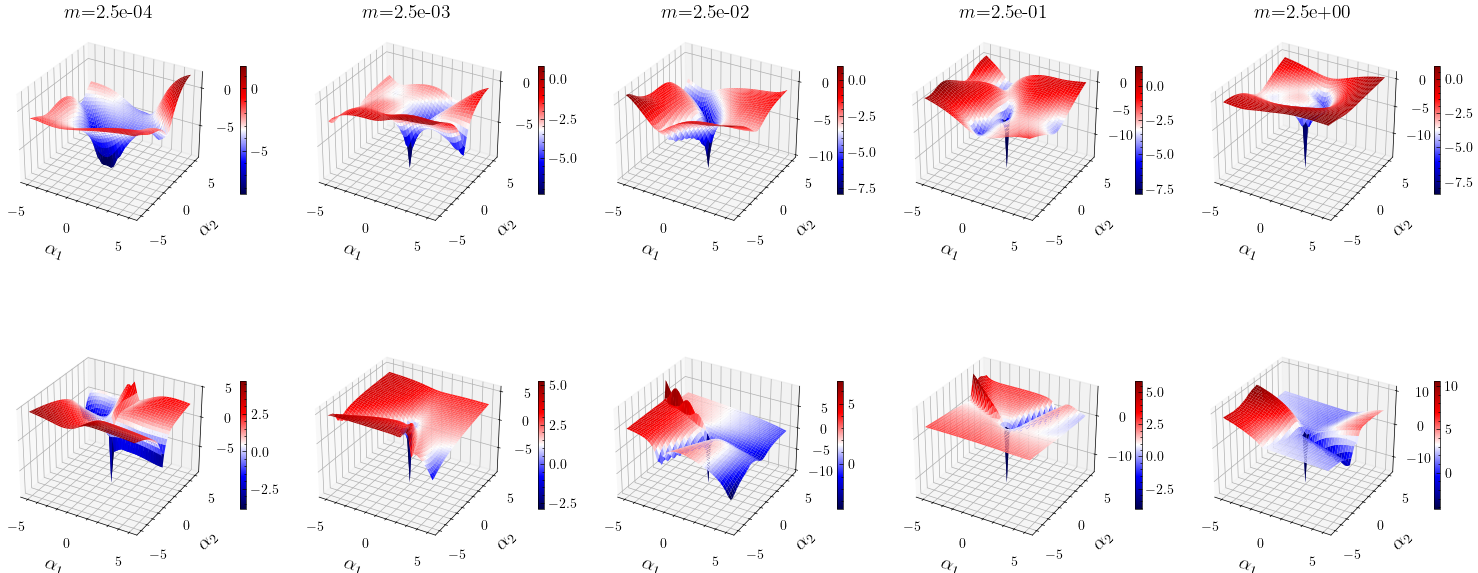

In [21]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(15, 12), subplot_kw={'projection': '3d'})

# Plot the random direction vector subspace projection of the loss landscape
for idx, param in enumerate(PARAM_LIST):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )
    
    fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    if TOP_PLOT:
        ax[0, idx].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )

    fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.15, orientation='vertical', pad=0.1)
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=14)
    # ax[1, idx].set_zlim(vmin, vmax)

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

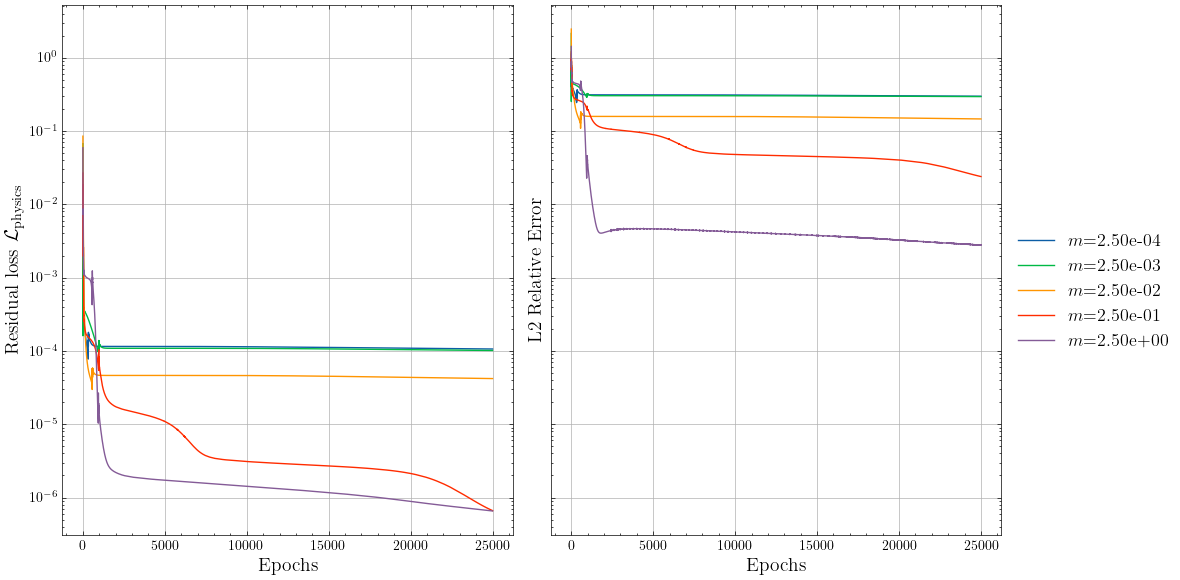

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the random direction vector subspace projection of the loss landscape
for residual_loss, param, l2_relative in zip(residual_losses_per_param, PARAM_LIST, test_losses_per_param_per_epoch):
    
    ax[0].semilogy(range(1, EPOCHS+1), residual_loss, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel(r"Residual loss $\mathcal{L}_{\mathrm{physics}}$", fontsize=14)
    # ax[0].legend(loc="best", fontsize=13)
    ax[0].grid()

    ax[1].semilogy(range(1, EPOCHS+1), l2_relative, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("L2 Relative Error", fontsize=14)
    ax[1].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[1].grid()

plt.tight_layout()

# # Output the plots as PDF to the desired directory
# loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

[]

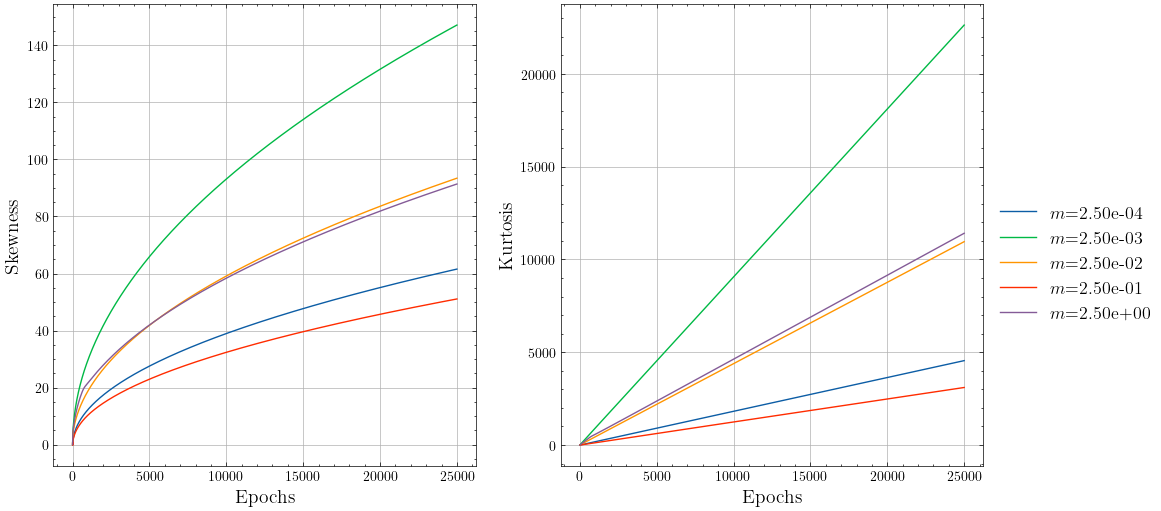

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for skewness, kurt, param in zip(skewness_per_param, kurtosis_per_param, PARAM_LIST): 
    ax[0].plot(range(1, EPOCHS+1), skewness, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel("Skewness", fontsize=14)
    ax[0].grid()

    ax[1].plot(range(1, EPOCHS+1), kurt, label=f"${VARYING_PARAM_NOTATION}$={param:.2e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel("Kurtosis", fontsize=14)
    ax[1].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[1].grid()

plt.plot()

Saving...


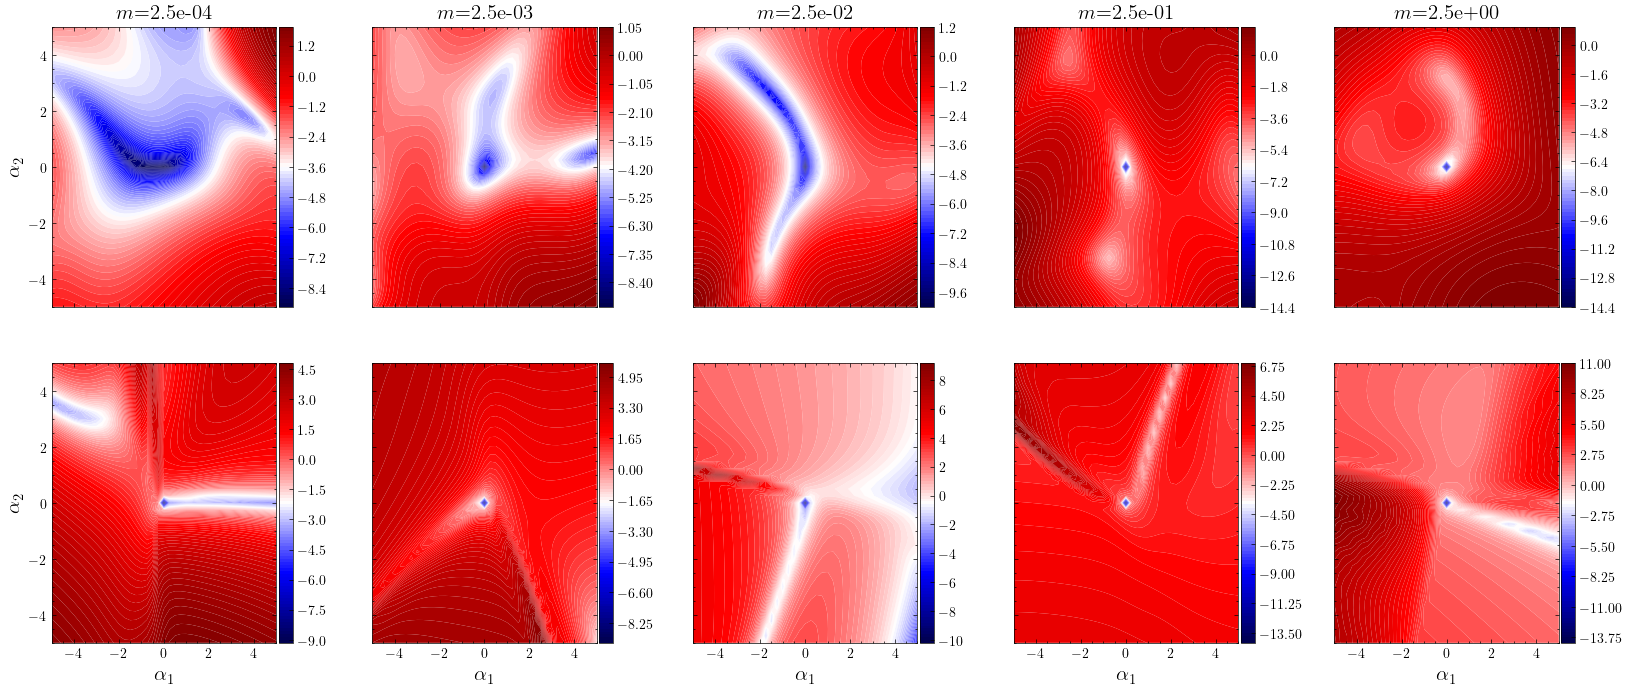

In [22]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
# levels = np.linspace(vmin, vmax, num_levels)

for index, (param) in enumerate(PARAM_LIST):
    contour_random = ax[0, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_random[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_random, ax=ax[0, index], shrink=1, orientation='vertical', pad=0.01)

    
    if index == 0:
        ax[0, index].set_ylabel(r'$\alpha_2$', fontsize=15)
        ax[1, index].set_ylabel(r'$\alpha_2$', fontsize=15)

    if TOP_PLOT:
        ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=15)


    contour_hessian = ax[1, index].contourf(
        ALPHA_1,
        ALPHA_2,
        np.log(loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )
    fig.colorbar(contour_hessian, ax=ax[1, index], shrink=1, orientation='vertical', pad=0.01)
    
    ax[1, index].set_xlabel(r'$\alpha_1$', fontsize=15)

# Shared colorbar
# cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)

contour_image_name = f"pinn/{VARYING_PARAM}_contour_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:46: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_15214/450371585.py:46: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_15214/450371585.py:47: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


L2 absolute error: 5.44e-01
L2 relative error: 2.98e-01
L2 absolute error: 5.55e-01
L2 relative error: 2.94e-01
L2 absolute error: 2.82e-01
L2 relative error: 1.46e-01
L2 absolute error: 6.95e-02
L2 relative error: 2.39e-02
L2 absolute error: 1.81e-02
L2 relative error: 2.77e-03
Saving...


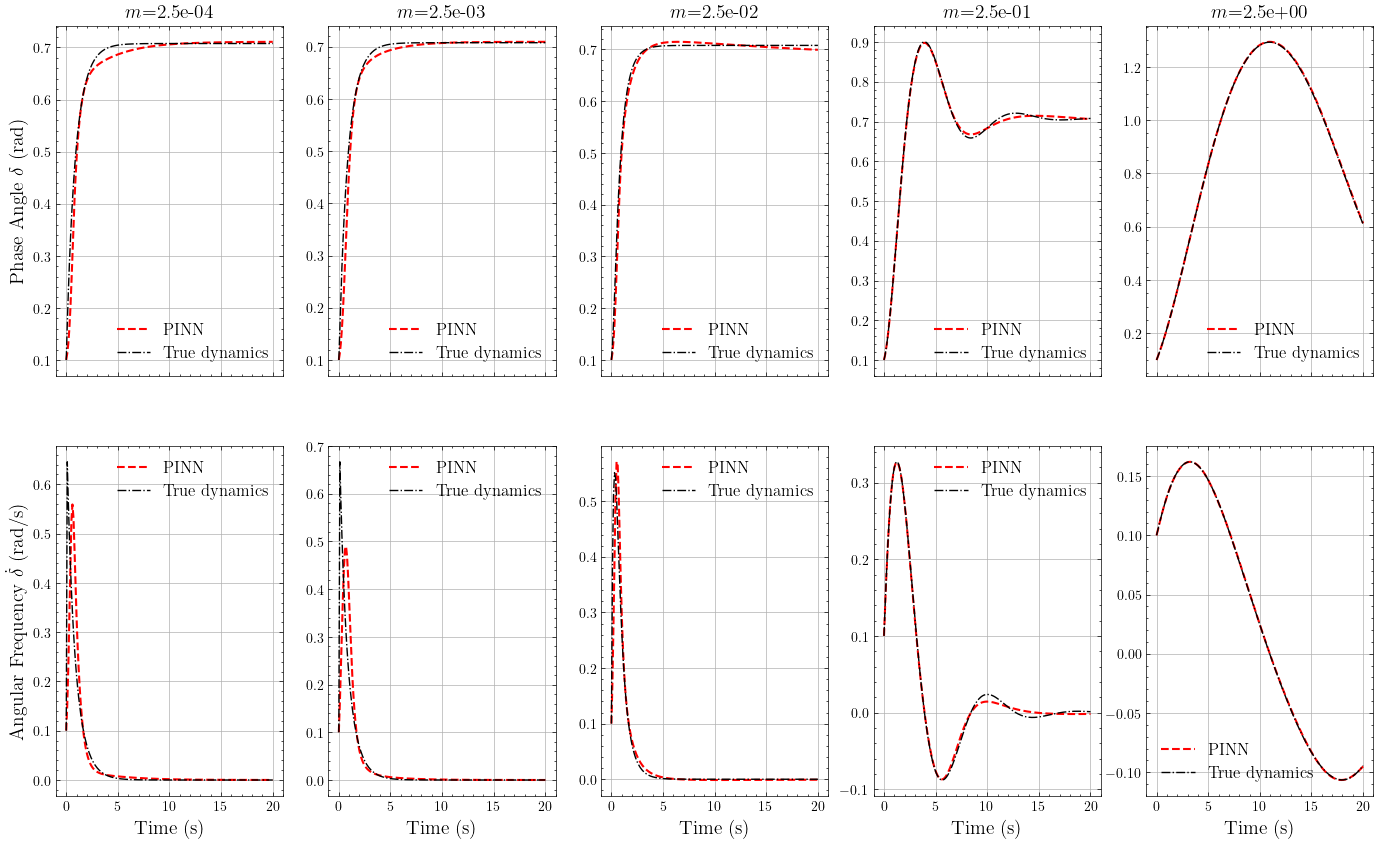

In [23]:
abs_errors_pinns = []
rel_errors_pinns = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, param in enumerate(PARAM_LIST):

    phase_angle_labels = numerical_solutions_exact_tensor[index, 0, :]

    angular_frequency_labels = numerical_solutions_exact_tensor[index, 1, :]

    phase_angle_pred = pinn_models[index].forward(data=times_tensor, initial_state=INITIAL_STATE)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=times_tensor,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    pred_vector = torch.stack(tensors=(phase_angle_pred, angular_frequency_pred), dim=0).squeeze()
    label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"L2 absolute error: {l2_abs:.2e}")
    print(f"L2 relative error: {l2_rel:.2e}")

    abs_errors_pinns.append(l2_abs)
    rel_errors_pinns.append(l2_rel)

    ax[0, index].plot(times_tensor.detach().numpy(), phase_angle_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[0, index].plot(times_tensor.detach().numpy(), phase_angle_labels, color="black", linestyle="-.", label="True dynamics")
    ax[0, index].grid()
    ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'${VARYING_PARAM_NOTATION}$='+f"{param:.1e}", fontsize=14)

    ax[1, index].plot(times_tensor.detach().numpy(), angular_frequency_pred.detach().numpy(), color='red', linestyle='--', label='PINN', linewidth=1.5)
    ax[1, index].plot(times_tensor.detach().numpy(), angular_frequency_labels, color="black", linestyle="-.", label="True dynamics")
    ax[1, index].grid()
    ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)

exact_vs_pred_image: str = f"pinn/{VARYING_PARAM}_pinn_vs_ground_truth_seed_{SEED}.pdf"

# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

Skewness=8.83506258480095
Kurtosis=81.59703775767541


/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_15214/705130864.py:64: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axes[0, idx].semilogy(dense_domain_set.detach().numpy(), residual_loss, 'o', marker='.')


Skewness=8.767724181786608
Kurtosis=81.14397806670065
Skewness=11.972849966949996
Kurtosis=153.38569518857506
Skewness=1.7046947363762106
Kurtosis=1.7338999346729365
Skewness=7.161328735011385
Kurtosis=59.31207630391751


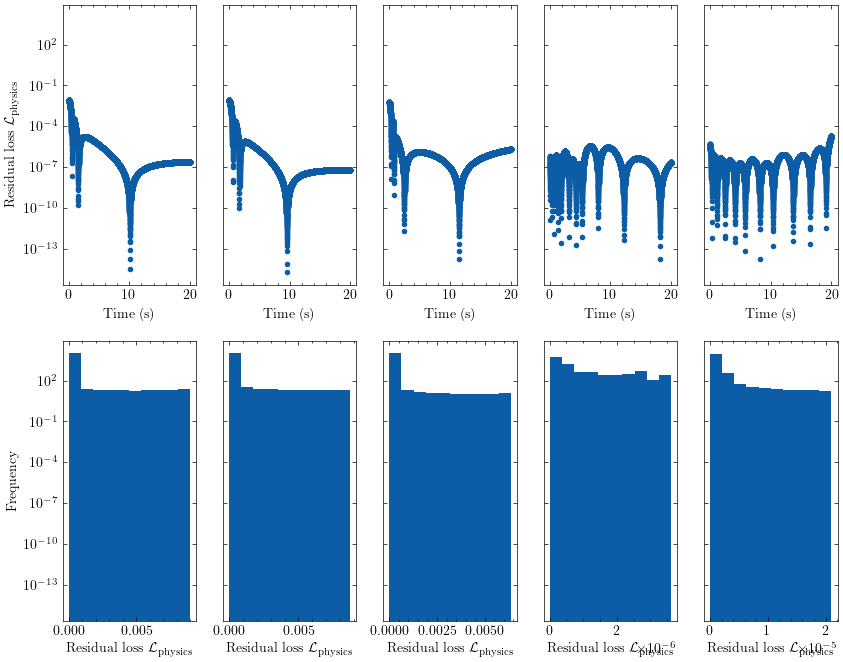

In [16]:
# Obtain collocation points sampled via LHS of size N_C
LHC = qmc.LatinHypercube(d=1)
dense_domain_set = LHC.random(n=N_C*10)
dense_domain_set = qmc.scale(
    dense_domain_set, T0, FINALTIME
).flatten()  # Scale from a unit interval [0,1] (default) to [t0,T]

dense_domain_set: torch.tensor = torch.tensor(
    data=dense_domain_set[:, None].astype(np.float32), requires_grad=True
).to(device=DEVICE)


fig, axes = plt.subplots(2, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    residual_loss = []

    for collocation_point in dense_domain_set:

        pinn = pinn_models[idx]

        phase_angle_pred = pinn.forward(data=collocation_point)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        angular_acceleration_pred = torch.autograd.grad(
            outputs=angular_frequency_pred,
            inputs=collocation_point,
            grad_outputs=torch.ones_like(angular_frequency_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        swing_inputs = SwingEquationInputs(
            phase_angle=phase_angle_pred,
            angular_frequency=angular_frequency_pred,
            angular_acceleration=angular_acceleration_pred,
            inertia=param,
            damping=DAMPING,
            mechanical_power=MECHANICAL_POWER,
            voltage_magnitude=VOLTAGE,
            voltages=VOLTAGES,
            phase_angles=PHASE_ANGLES,
            susceptances=SUSCEPTANCES,
            controller_proportional=None,
            controller_integral=None,
        )

        residual = physics_based_loss(swing_inputs=swing_inputs, include_controllers=False)
        residual_loss.append(residual.item())

    skewness_val = skew(a=np.array(residual_loss))
    kurtosis_val = kurtosis(a=np.array(residual_loss), fisher=True)

    print(f"Skewness={skewness_val}\nKurtosis={kurtosis_val}")

    axes[0, idx].semilogy(dense_domain_set.detach().numpy(), residual_loss, 'o', marker='.')
    axes[0, idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[0, idx].set_ylabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')
        axes[1, idx].set_ylabel("Frequency")

    axes[1, idx].hist(residual_loss, log=False)
    axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')

plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


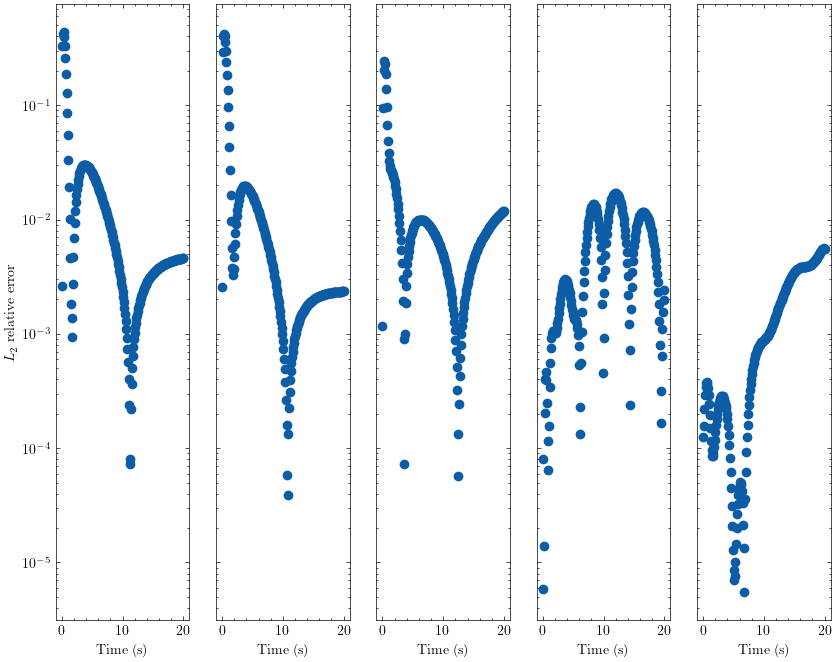

In [17]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(10, 8), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    test_performance = []

    for time_idx, time in enumerate(times_tensor):
        
        pinn = pinn_models[idx]

        ground_truth_phase_angle = numerical_solutions_exact_tensor[idx, 0, time_idx].view(1)

        phase_angle_pred = pinn.forward(data=time)

        angular_frequency_pred = torch.autograd.grad(
            outputs=phase_angle_pred,
            inputs=time,
            grad_outputs=torch.ones_like(phase_angle_pred),
            create_graph=True,
            retain_graph=True,
        )[0]

        _, l2_rel = l2_error(pred=phase_angle_pred, ground_truth=ground_truth_phase_angle, dim=0)
        test_performance.append(l2_rel.item())

    print(type(numerical_domain))
    axes[idx].semilogy(numerical_domain, test_performance, 'o')
    axes[idx].set_xlabel('Time (s)')

    if idx == 0:
        axes[idx].set_ylabel(r"$L_2$ relative error")

plt.show()

Saving...


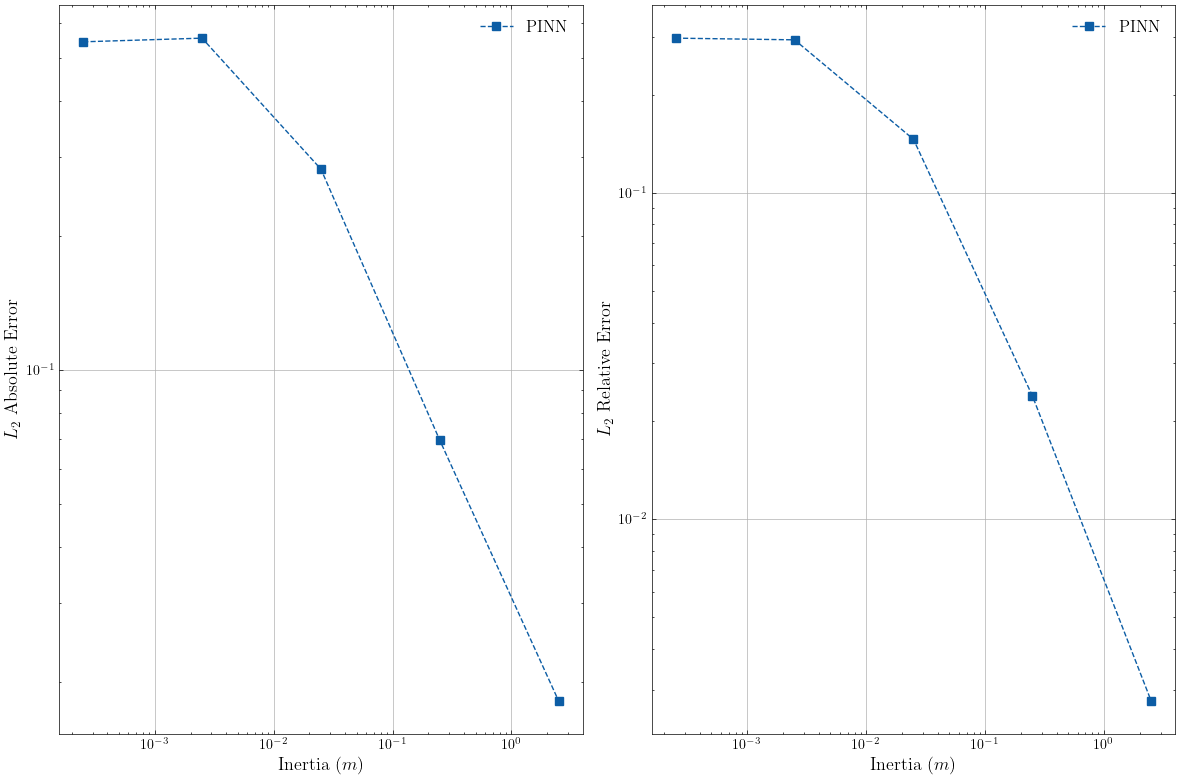

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].loglog(PARAM_LIST, [ls.detach().numpy() for ls in abs_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[0].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[0].set_ylabel("$L_{2}$ Absolute Error", fontsize=13)
ax[0].legend(fontsize=12)
ax[0].grid()

ax[1].loglog(PARAM_LIST, [ls.detach().numpy() for ls in rel_errors_pinns], marker='s', linestyle='--', label="PINN")    
ax[1].set_xlabel(f"{VARYING_PARAM.title()} (${VARYING_PARAM_NOTATION}$)", fontsize=13)
ax[1].set_ylabel("$L_{2}$ Relative Error", fontsize=13)
# ax[1].set_xticklabels()
ax[1].legend(fontsize=12)
ax[1].grid()

plt.subplots_adjust(left=0.1, right=0.9, hspace=-0.7)
plt.tight_layout()

test_error: str = f"{VARYING_PARAM}_l2_test_error_random_seed_{SEED}.pdf"

if SAVE:
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+test_error, format="pdf", bbox_inches="tight")


<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_15214/924917055.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)


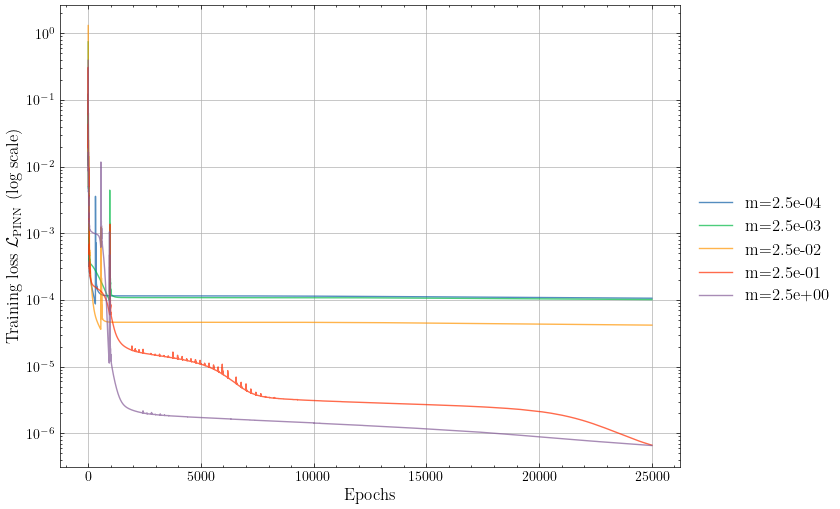

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for (param, training_loss) in zip(PARAM_LIST, training_losses_per_param):
    ax.semilogy(
        range(1, EPOCHS+1),
        training_loss,
        alpha=0.7,
        label=f"{VARYING_PARAM_NOTATION}={param:.1e}"
    )

ax.set_ylabel("Training loss $\mathcal{L}_{\mathrm{PINN}}$ (log scale)", fontsize=12)
ax.set_xlabel("Epochs", fontsize=12)
ax.grid()
ax.legend(loc="best", fontsize=12, bbox_to_anchor=(1.25, 0.6), borderaxespad=0.)

training_losses_plot = f"{VARYING_PARAM}_training_losses_seed_{SEED}.pdf"

# plt.savefig(fname=PATH_TO_IM_DIR+training_losses_plot, format="pdf", bbox_inches="tight")

plt.show()